# Data

In [24]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [25]:
# Load the data
data = pd.read_csv('model_data_emea.csv')

# Check for missing values
missing_values = data.isnull().sum()

In [26]:
data.set_index("Week", inplace = True)

In [27]:
forecast = pd.read_csv('validation_prediction_emea.csv')

# Check for missing values
missing_values = forecast.isnull().sum()

forecast.set_index("Week", inplace = True)

In [28]:
dictionary={}
combined = pd.concat([data, forecast])
for i in range(len(combined.columns)):
  dictionary[combined.columns[i]]=combined[combined.columns[i]].unique()

In [29]:
data_num = data.copy(deep=True)
forecast_num = forecast.copy(deep=True)

str_to_num = {}

# Iterate over the columns in the dictionary
for col in dictionary:
    # Check if the column exists in the dataframes and contains non-numeric data
    if col in data_num.columns and data_num[col].dtype == object:
        # Create a mapping for this column
        unique_values = dictionary[col]
        mapping = {val: idx for idx, val in enumerate(unique_values)}

        # Apply the mapping to the dataframes
        data_num[col] = data_num[col].map(mapping)
        forecast_num[col] = forecast_num[col].map(mapping)

        # Store the mapping
        str_to_num[col] = mapping

# The data_num and forecast_num now contain numeric values where applicable, and str_to_num contains the mappings

In [30]:
data_num

SKU  Region  Demand  Global Status  DNA Collection   DNA Category   \
Week                                                                            
2021-W39     0       0     1.0              0                0              0   
2021-W40     0       0     2.0              0                0              0   
2021-W41     0       0     7.0              0                0              0   
2021-W42     0       0     1.0              0                0              0   
2021-W43     0       0     2.0              0                0              0   
...        ...     ...     ...            ...              ...            ...   
2023-W5   9556       0   231.0              3                1              6   
2023-W6   9556       0   231.0              3                1              6   
2023-W7   9556       0   283.0              3                1              6   
2023-W8   9556       0   180.0              3                1              6   
2023-W9   9556       0   216.0              3                1              6   

          DNA Sub Category   DNA Metal   DNA Material   DNA Stones   ...  \
Week                                                                 ...   
2021-W39                  0           0              0            0  ...   
2021-W40                  0           0              0            0  ...   
2021-W41                  0           0              0            0  ...   
2021-W42                  0           0              0            0  ...   
2021-W43                  0           0              0            0  ...   
...                     ...         ...            ...          ...  ...   
2023-W5                  19          10              0            0  ...   
2023-W6                  19          10              0            0  ...   
2023-W7                  19          10              0            0  ...   
2023-W8                  19          10              0            0  ...   
2023-W9                  19          10              0            0  ...   

          Date Item Discontinue  Design Variation  Campaign Id  Theme Id  \
Week                                                                       
2021-W39                      0                 0            0         0   
2021-W40                      0                 0            0         0   
2021-W41                      0                 0            0         0   
2021-W42                      0                 0            0         0   
2021-W43                      0                 0            0         0   
...                         ...               ...          ...       ...   
2023-W5                       0              4693            1         0   
2023-W6                       0              4693            1         0   
2023-W7                       0              4693            1         0   
2023-W8                       0              4693            1         0   
2023-W9                       0              4693            1         0   

          Theme Description  Year  Week_Number  Seasonality  Evolving State  \
Week                                                                          
2021-W39                  0  2021           39            0               0   
2021-W40                  0  2021           40            0               0   
2021-W41                  0  2021           41            0               0   
2021-W42                  0  2021           42            0               1   
2021-W43                  0  2021           43            0               1   
...                     ...   ...          ...          ...             ...   
2023-W5                   0  2023            5            1               1   
2023-W6                   0  2023            6            1               1   
2023-W7                   0  2023            7            1               1   
2023-W8                   0  2023            8            0               1   
2023-W9                   0  20

In [31]:
data_num.to_csv("data_num_emea.csv", index = True)
forecast_num.to_csv("forecast_num_emea.csv", index = True)

# Rest

In [32]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import random

In [33]:
data_num = pd.read_csv('data_num_emea.csv')
data_num.set_index("Week", inplace = True)

forecast_num = pd.read_csv('forecast_num_emea.csv')
forecast_num.set_index("Week", inplace = True)

In [34]:
combined_df = pd.concat([data_num, forecast_num[:-52]])

##
train = combined_df[combined_df['Year'] != 2023]
test = combined_df[combined_df['Year'] == 2023]
##

#X = combined_df.drop(columns=['Demand'])
#y = combined_df['Demand']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
X_train = train.drop(columns=['Demand'])
y_train = train['Demand']
X_test = test.drop(columns=['Demand'])
y_test = test['Demand']
##

forecast_num_last52 = forecast_num[-52:]

X_forecast  = forecast_num_last52.drop(columns=['Demand'])
y_forecast = forecast_num_last52['Demand']

In [35]:
X_train

SKU  Region  Global Status  DNA Collection   DNA Category   \
Week                                                                    
2021-W39     0       0              0                0              0   
2021-W40     0       0              0                0              0   
2021-W41     0       0              0                0              0   
2021-W42     0       0              0                0              0   
2021-W43     0       0              0                0              0   
...        ...     ...            ...              ...            ...   
2022-W45  9557       0              0                1              0   
2022-W46  9557       0              0                1              0   
2022-W47  9557       0              0                1              0   
2022-W48  9557       0              0                1              0   
2022-W49  9557       0              0                1              0   

          DNA Sub Category   DNA Metal   DNA Material   DNA Stones   \
Week                                                                  
2021-W39                  0           0              0            0   
2021-W40                  0           0              0            0   
2021-W41                  0           0              0            0   
2021-W42                  0           0              0            0   
2021-W43                  0           0              0            0   
...                     ...         ...            ...          ...   
2022-W45                  0          10              0            0   
2022-W46                  0          10              0            0   
2022-W47                  0          10              0            0   
2022-W48                  0          10              0            0   
2022-W49                  0          10              0            0   

          DNA Color   ...  Date Item Discontinue  Design Variation  \
Week                  ...                                            
2021-W39           0  ...                      0                 0   
2021-W40           0  ...                      0                 0   
2021-W41           0  ...                      0                 0   
2021-W42           0  ...                      0                 0   
2021-W43           0  ...                      0                 0   
...              ...  ...                    ...               ...   
2022-W45           0  ...                      0              4694   
2022-W46           0  ...                      0              4694   
2022-W47           0  ...                      0              4694   
2022-W48           0  ...                      0              4694   
2022-W49           0  ...                      0              4694   

          Campaign Id  Theme Id  Theme Description  Year  Week_Number  \
Week                                                                    
2021-W39            0         0                  0  2021           39   
2021-W40            0         0                  0  2021           40   
2021-W41            0         0                  0  2021           41   
2021-W42            0         0                  0  2021           42   
2021-W43            0         0                  0  2021           43   
...               ...       ...                ...   ...          ...   
2022-W45            1         0                  0  2022           45   
2022-W46            1         0                  0  2022           46   
2022-W47            1         0                  0  2022           47   
2022-W48            1         0                  0  2022           48   
2022-W49            1         0                  0  2022           49   

          Seasonality  Evolving State  Buckets  
Week                                            
2021-W39            0               0        0  
2021-W40            0               0        0  
2021-W41            0               0        0  
2021-W42            0          

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_forecast_scaled = scaler.transform(X_forecast)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

##
X_val_tensor = torch.tensor(X_test_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_test.values.astype(np.float32))
##

X_forecast_tensor = torch.tensor(X_forecast_scaled, dtype=torch.float32)

# Create Data Loaders

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

##
val_data = TensorDataset(X_val_tensor, y_val_tensor)
##

forecast_data = TensorDataset(X_forecast_tensor)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

##
val_loader = DataLoader(val_data, batch_size=128)
##

forecast_loader = DataLoader(forecast_data, batch_size=128, shuffle=False)

In [37]:
### Manual Weights

# Transformers weigts
#manual_weights_transformers = {
#    'SKU': 1.5, ##
#    'Week': 2.0, 
#    'Region': 1.0, 
#    'Global Status': 1.0, 
#    'DNA Collection ': 1.0,
#    'DNA Category ': 1.5, 
#    'DNA Sub Category ': 1.5, 
#    'DNA Metal ': 1.5, 
#    'DNA Material ': 1.5, 
#    'DNA Stones ': 1.5, 
#    'DNA Color ': 1.5, 
#    'DNA Size ': 1.5, 
#    'Date Item Introduced': 1.0,
#    'Date Item Discontinue': 1.0, 
#    'Design Variation': 2.5, 
#    'Campaign Id': 2.0, 
#    'Theme Id': 1.0,
#    'Theme Description': 1.0, 
#    'Year': 2.0, 
#    'Week_Number': 2.0, ##
#    'Seasonality': 3.0,
#    'Evolving State': 3.0, 
#    'Buckets': 1.0
#}

# LSTM weights
manual_weights_LSTM = {
     'SKU': 1.0,
     'Week': 1.0,
     'Region': 1.0,
     'Global Status': 1.0,
     'DNA Collection ': 1.0,
     'DNA Category ': 1.5, #
     'DNA Sub Category ': 1.5, #
     'DNA Metal ': 1.5, #
     'DNA Material ': 1.5, #
     'DNA Stones ': 1.5, #
     'DNA Color ': 1.5, #
     'DNA Size ': 1.5, #
     'Date Item Introduced': 1.0,
     'Date Item Discontinue': 1.0,
     'Design Variation': 2.5, #
     'Campaign Id': 2.0,
     'Theme Id': 1.0,
     'Theme Description': 1.0,
     'Year': 2.0,
     'Week_Number': 2.0,
     'Seasonality': 4.0,
     'Evolving State': 4.0,
     'Buckets': 1.0
 }

manual_weights_transformers = manual_weights_LSTM

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

class ManualFeatureAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights):
        super(ManualFeatureAttention, self).__init__()
        self.num_features = num_features
        self.feature_names = feature_names
        self.manual_weights = manual_weights

        # Initialize attention weights
        self.attention_weights = nn.Parameter(torch.ones(num_features))

        # Manually adjust weights for specified features
        for i, feature_name in enumerate(feature_names):
            if feature_name in manual_weights:
                self.attention_weights.data[i] = manual_weights[feature_name]

    #def forward(self, x):
        # Apply attention weights
    #    x = x * self.attention_weights
    #    return x
    def forward(self, x):
        # Dynamically resize attention weights if necessary
        if x.size(1) != self.attention_weights.size(0):
            # Resize attention weights to match input size
            # Note: This resizing strategy should be carefully chosen
            self.attention_weights = nn.Parameter(torch.ones(x.size(1)))
        
        # Apply attention weights
        x = x * self.attention_weights
        return x


In [39]:
# Transformers Model
class NeuralNetWithManualAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights):
        super(NeuralNetWithManualAttention, self).__init__()
        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        #
        self.layer1 = nn.Linear(num_features, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)             ##0.15      0.2       0.25
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.1)             ## 0.15     0.2
        self.layer3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.03)             ## 0.1       0.15
        self.layer4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.01)            ## 0.05      0.1
        self.layer5 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.feature_attention(x)
        #
        x = self.dropout1(nn.functional.leaky_relu(self.batch_norm1(self.layer1(x)), 0.01))
        x = self.dropout2(nn.functional.leaky_relu(self.batch_norm2(self.layer2(x)), 0.01))
        x = self.dropout3(nn.functional.leaky_relu(self.batch_norm3(self.layer3(x)), 0.01))
        x = self.dropout4(nn.functional.leaky_relu(self.batch_norm4(self.layer4(x)), 0.01))
        x = self.layer5(x)
        return x

# Create model instance
model_transformers = NeuralNetWithManualAttention(X_train_tensor.shape[1], X_train.columns, manual_weights_transformers)


In [40]:
# Transformers Model 2
class NeuralNetWithManualAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights, num_past_weeks, hidden_size):
        super(NeuralNetWithManualAttention, self).__init__()
        ########### Change
        self.num_past_weeks = num_past_weeks
        # Time Series Processing Layer (LSTM)
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, batch_first=True)
        ###########

        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        #
        self.layer1 = nn.Linear(num_features, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)             ##0.15      0.2       0.25
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.1)             ## 0.15     0.2
        self.layer3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.03)             ## 0.1       0.15
        self.layer4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.01)            ## 0.05      0.1
        self.layer5 = nn.Linear(16, 1)

    def forward(self, x):
        ############# Change
        # Reshape x to include time series data: [batch_size, num_past_weeks, num_features]
        x = x.view(-1, self.num_past_weeks, x.size(1))

        # Process time series data
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last time step
        #############

        x = self.feature_attention(x)
        #
        x = self.dropout1(nn.functional.leaky_relu(self.batch_norm1(self.layer1(x)), 0.01))
        x = self.dropout2(nn.functional.leaky_relu(self.batch_norm2(self.layer2(x)), 0.01))
        x = self.dropout3(nn.functional.leaky_relu(self.batch_norm3(self.layer3(x)), 0.01))
        x = self.dropout4(nn.functional.leaky_relu(self.batch_norm4(self.layer4(x)), 0.01))
        x = self.layer5(x)
        return x

# Create model instance
model_transformers = NeuralNetWithManualAttention(X_train_tensor.shape[1], X_train.columns, manual_weights_transformers)


TypeError: NeuralNetWithManualAttention.__init__() missing 2 required positional arguments: 'num_past_weeks' and 'hidden_size'

In [ ]:
#def pad_sequence(sequence, max_length, num_features, padding_value=0):
#    padded_sequence = torch.full((max_length, num_features), padding_value)
#    if sequence.shape[0] > 0:  # Handling empty sequences
#        padded_sequence[-sequence.shape[0]:, :] = sequence
#    return padded_sequence

#num_past_weeks = 4
#padding_value = 0  # or any value you choose
#num_features = X_train_tensor.shape[-1]  # Assuming the last dimension is features

# Assuming you have a way to identify each SKU's data in X_train_tensor
# For simplicity, let's say `sku_indices` is a dictionary where keys are SKUs and values are indices in X_train_tensor
#padded_data = []
#for sku, indices in sku_indices.items():
#    sku_data = X_train_tensor[indices]
#    if sku_data.shape[0] < num_past_weeks:
#        sku_data = pad_sequence(sku_data, num_past_weeks, num_features, padding_value)
#    padded_data.append(sku_data)

# Concatenating all SKUs data into a single tensor
#X_train_padded = torch.cat(padded_data, dim=0)


In [41]:
# Transformers Model 3
class NeuralNetWithManualAttention(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights, num_past_weeks):
        super(NeuralNetWithManualAttention, self).__init__()
        
        ########### Change
        self.num_past_weeks = num_past_weeks

        # Conv1D Layer for Time Series
        self.conv1 = nn.Conv1d(in_channels=num_past_weeks, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        ###########

        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        #
        # Adjust the input size of the first linear layer
        self.layer1 = nn.Linear(num_features * 32, 128)  # Adjusted input size
        ##
        #self.layer1 = nn.Linear(num_features, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)             ## 0.2   0.15      0.2       0.25
        self.layer2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.1)             ## 0.1   0.15     0.2
        self.layer3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.03)             ## 0.03    0.1       0.15
        self.layer4 = nn.Linear(32, 16)
        self.batch_norm4 = nn.BatchNorm1d(16)
        self.dropout4 = nn.Dropout(0.01)            ## 0.01    0.05      0.1
        #self.layer5 = nn.Linear(16, 1)

         # Additional layers
        #self.layer5 = nn.Linear(16, 8)
        #self.batch_norm5 = nn.BatchNorm1d(8)
        #self.dropout5 = nn.Dropout(0.01)          ## 0.01

        #self.layer6 = nn.Linear(8, 4)
        #self.batch_norm6 = nn.BatchNorm1d(4)
        #self.dropout6 = nn.Dropout(0.01)            ## 0.01

        # Final layer
        self.final_layer = nn.Linear(16, 1)

#    def forward(self, x):
#        ##########
#        # Ensure batch size is maintained throughout the model
#        original_batch_size = x.size(0)
#        ##########
#        ########### Change
#        # Reshape x for Conv1D: [batch_size, num_past_weeks, num_features]
#        x = x.view(-1, self.num_past_weeks, x.size(1))
#
#        # Process time series data with Conv1D
#        x = nn.functional.relu(self.conv1(x))
#        x = nn.functional.relu(self.conv2(x))
#
#        # Flatten and feed into the rest of the network
#        x = x.view(x.size(0), -1)
#        ############
#        
#        x = self.feature_attention(x)
#        #
#        x = self.dropout1(nn.functional.leaky_relu(self.batch_norm1(self.layer1(x)), 0.01))
#        x = self.dropout2(nn.functional.leaky_relu(self.batch_norm2(self.layer2(x)), 0.01))
#        x = self.dropout3(nn.functional.leaky_relu(self.batch_norm3(self.layer3(x)), 0.01))
#        x = self.dropout4(nn.functional.leaky_relu(self.batch_norm4(self.layer4(x)), 0.01))
#        x = self.layer5(x)
#
#        ##########
#        # Before the final output, ensure the batch size matches the original
#        x = x.view(original_batch_size, -1)
#        ##########
#        return x
    
    def forward(self, x):
        # Store the original batch size for later use
        original_batch_size = x.size(0)

        # Padding to 24 features
        padding_size = 24 - x.size(1)
        if padding_size > 0:
            pad = torch.zeros(original_batch_size, padding_size).to(x.device)
            x = torch.cat([x, pad], dim=1)

        # Now x has 24 features, reshape considering 4 weeks
        x = x.view(original_batch_size, self.num_past_weeks, -1)

        # Process time series data with Conv1D
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))

        # Flatten and feed into the rest of the network
        x = x.view(original_batch_size, -1)

        # Calculate the size of the flattened features
        flattened_size = x.size(1)

        # Adjust the first linear layer to match the flattened size
        if self.layer1.in_features != flattened_size:
            self.layer1 = nn.Linear(flattened_size, 128).to(x.device)

        # Apply the feature attention
        x = self.feature_attention(x)

        # Process through the remaining layers
        x = self.dropout1(nn.functional.leaky_relu(self.batch_norm1(self.layer1(x)), 0.01))
        x = self.dropout2(nn.functional.leaky_relu(self.batch_norm2(self.layer2(x)), 0.01))
        x = self.dropout3(nn.functional.leaky_relu(self.batch_norm3(self.layer3(x)), 0.01))
        x = self.dropout4(nn.functional.leaky_relu(self.batch_norm4(self.layer4(x)), 0.01))
        #x = self.layer5(x)

        # Additional layers
        #x = self.dropout5(nn.functional.leaky_relu(self.batch_norm5(self.layer5(x)), 0.01))
        #x = self.dropout6(nn.functional.leaky_relu(self.batch_norm6(self.layer6(x)), 0.01))

        x = self.final_layer(x)

        return x



# Create model instance
model_transformers = NeuralNetWithManualAttention(X_train_tensor.shape[1], X_train.columns, manual_weights_transformers, num_past_weeks=4)


In [42]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_features, feature_names, manual_weights, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.feature_attention = ManualFeatureAttention(num_features, feature_names, manual_weights)
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        
        # Additional intermediate dense layer with ReLU activation
        self.intermediate_linear = nn.Linear(hidden_size, hidden_size * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)  # You can adjust the dropout probability as needed
        
        # Output layer
        self.output_linear = nn.Linear(hidden_size * 2, 1)
        
        # Sigmoid activation function for the output layer, remove if it's a regression problem
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.feature_attention(x)
        x, (hidden, cell) = self.lstm(x)
        
        # We only use the last hidden state
        x = hidden[-1]
        
        # Passing through the intermediate dense layer with ReLU activation and dropout
        #x = self.dropout(self.relu(self.intermediate_linear(x)))
        x = self.dropout(nn.functional.leaky_relu(self.intermediate_linear(x)))
        
        # Final output layer
        x = self.output_linear(x)
        
        # Apply sigmoid activation if it's a classification problem
        # If it's a regression problem, you might want to comment out the line below
        #x = self.sigmoid(x)
        x = x.squeeze()  # This will change shape from [batch_size, 1] to [batch_size]

        
        return x

# Model parameters
input_dim = X_train.shape[1]
hidden_dim = 5
layer_dim = 5
output_dim = 1

# Correctly defined feature names from the DataFrame
feature_names = combined_df.columns.tolist()
feature_names.remove('Demand')

model_LSTM = LSTMModel(num_features=len(feature_names), feature_names=feature_names, manual_weights=manual_weights_LSTM, hidden_size=hidden_dim, num_layers=layer_dim)

#model_LSTM = LSTMModel(num_features=len(feature_names), feature_names, manual_weights_LSTM, hidden_size=hidden_dim, num_layers=layer_dim)

In [43]:
def refresh_parameters(model_type,model,extra_epoch=0,epochs=250):
    # Loss function criterion
    criterion = nn.L1Loss()

    # Optimizer function
    optimizer = optim.AdamW(model.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

    # Initialize early stopping object
    early_stopping = EarlyStopping(patience=25, verbose=True)

    epochs = epochs
    extra_epoch = extra_epoch
    plot_every_n_epochs = 10

    if model_type == "Transformers":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, factor=0.75, verbose=True)

    elif model_type == "LSTM":     
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, factor=0.5, verbose=True)
    
    return criterion, optimizer, early_stopping, epochs, extra_epoch, plot_every_n_epochs, scheduler

In [44]:
def training_loop(model_type,model,extra_epoch,train_loader,test_loader,val_loader,epochs=25,train_losses=[],val_losses=[]):
    
    criterion, optimizer, early_stopping, epochs, extra_epoch, plot_every_n_epochs, scheduler = refresh_parameters(model_type,model,extra_epoch,epochs)
    
    #val_loader = test_loader

    if extra_epoch == 0:
        train_losses = []
        val_losses = []

    if model_type == "Transformers":
        # Transformers training loop
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                ##
                #print("Output size:", outputs.size(), "Label size after unsqueeze:", labels.unsqueeze(1).size())  # Debug statement
                ##
                loss = criterion(outputs, labels.unsqueeze(1))
                loss.backward()

                # Clip gradients: gradients are modified in place
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

                optimizer.step()
                total_train_loss += loss.item()
            avg_train_loss = total_train_loss / len(train_loader)

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    total_val_loss += loss.item()
            avg_val_loss = total_val_loss / len(test_loader)

            # Step the scheduler based on the validation loss
            scheduler.step(avg_val_loss)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update loss plot
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'Training and Validation Loss (Epoch {extra_epoch+epoch+1})')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Update actual vs predicted plot
            if epoch % plot_every_n_epochs == 0 or epoch == epochs - 1:
                model.eval()
                predictions = []
                actuals = []
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        outputs = model(inputs)
                        predictions.extend(outputs.view(-1).tolist())
                        actuals.extend(labels.tolist())
                plt.figure(figsize=(10, 10))
                plt.axis([0, 5000, 0, 5000])
                plt.scatter(actuals, predictions, alpha=0.5)
                plt.title(f'Actual vs Predicted Values (Epoch {extra_epoch+epoch+1})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')
                plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
                plt.show()

            # Call early stopping
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            
            print(f"Epoch {extra_epoch+epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))

    elif model_type == "LSTM":
        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            total_train_loss = 0

            for inputs, labels in train_loader:
                # Reshape inputs for LSTM: [batch_size, time_steps, features]
                inputs = inputs.view(inputs.shape[0], -1, input_dim)

                optimizer.zero_grad()  # Clear the gradients
                outputs = model(inputs)  # Forward pass: compute the output
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                optimizer.step()  # Perform a single optimization step (parameter update)
                total_train_loss += loss.item()  # Accumulate the training loss

            # Calculate average training loss for the epoch 
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0
            #
            with torch.no_grad():  # Inference mode, gradients not computed
                for inputs, labels in val_loader:
                    # Reshape inputs for LSTM
                    inputs = inputs.view(inputs.shape[0], -1, input_dim)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    
            # Calculate average validation loss for the epoch
            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Step the scheduler based on the validation loss
            scheduler.step(avg_val_loss)

            # Update loss plot
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.title(f'Training and Validation Loss (Epoch {epoch+1})')  # Corrected for extra_epoch+epoch+1 if extra_epoch is not defined earlier in your code.
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Update actual vs predicted plot
            if epoch % plot_every_n_epochs == 0 or epoch == epochs - 1:
                model.eval()
                predictions = []
                actuals = []
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        # Reshape inputs for LSTM
                        inputs = inputs.view(inputs.shape[0], -1, input_dim)
                        outputs = model(inputs)
                        predictions.extend(outputs.view(-1).tolist())
                        actuals.extend(labels.tolist())
                plt.figure(figsize=(10, 10))
                plt.axis([0, 5000, 0, 5000])
                #print(len(actuals))
                #print(len(predictions))
                plt.scatter(actuals, predictions, alpha=0.5)
                plt.title(f'Actual vs Predicted Values (Epoch {extra_epoch+epoch+1})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')
                plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
                plt.show()

            # Call early stopping
            early_stopping(avg_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            # Print training and validation loss
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")
        # Load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_losses, val_losses

In [45]:
def plot_results(train_losses,val_losses,model_type,model):
    if model_type == "Transformers":
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predictions.extend(outputs.view(-1).tolist())
                actuals.extend(labels.tolist())

        plt.figure(figsize=(10, 6))
        plt.axis([0, 5000, 0, 5000])
        plt.scatter(actuals, predictions, alpha=0.5)
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red') # Diagonal line
        plt.show()
    
    elif model_type == "LSTM":
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Training and Validation Loss')  # Corrected for extra_epoch+epoch+1 if extra_epoch is not defined earlier in your code.
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.view(inputs.shape[0], -1, input_dim)
                outputs = model(inputs)
                #print(f'Predictions:{outputs.view(-1).tolist()}')
                #print(f'actuals:{labels.tolist()}')
                predictions.extend(outputs.view(-1).tolist())
                actuals.extend(labels.tolist())
        
        plt.figure(figsize=(10, 10))
        plt.axis([0, 5000, 0, 5000])
        plt.scatter(actuals, predictions, alpha=0.5)
        #plt.plot(actuals, color='green')
        #plt.plot(predictions, color='blue')

        plt.title(f'Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Diagonal line
        plt.show()
    
    return  actuals, predictions

In [46]:
def validation(model_type,model,forecast_loader,y_forecast):
    if model_type == "Transformers":
        model.eval()
        predictions_forecast = []

        with torch.no_grad():
            for inputs in forecast_loader:
                outputs = model(inputs[0])  # Unpack the single value
                predictions_forecast.extend(outputs.view(-1).tolist())

        # Plotting
        plt.figure(figsize=(12, 6))

        # Plot actual values
        plt.plot(y_forecast.values, label='Actual Demand', color='blue')  # Use y_forecast directly

        # Plot predicted values
        plt.plot(predictions_forecast, label='Predicted Demand', color='red')

        plt.title('Actual vs Predicted Demand')
        plt.xlabel('Data Points')
        plt.ylabel('Demand')
        plt.legend()
        plt.show()

    elif model_type == "LSTM":
        # Ensure the model is in evaluation mode
        model.eval()
        
        # Initialize an empty list to store predictions
        predictions_forecast = []
        
        # Disable gradient computation for inference
        with torch.no_grad():
            for batch in forecast_loader:
                # Unpack the batch which is a one-element tuple
                inputs = batch[0]
        
                # Check the shape of inputs and reshape if necessary
                if len(inputs.shape) == 2:  # Assuming inputs need to be 3D for the LSTM
                    inputs = inputs.view(inputs.shape[0], -1, input_dim)
        
                # Generate predictions
                outputs = model(inputs)
        
                # Extend the predictions list
                predictions_forecast.extend(outputs.view(-1).tolist())
        
        # Rest of the code for comparison with actual values...
        # Convert predictions to a NumPy array for easier handling
        predictions_forecast = np.array(predictions_forecast)
        
        # Since y_forecast is a pandas Series, ensure it's a NumPy array
        y_forecast_np = y_forecast.values
        
        
        # Plot actual vs predicted values for visualization
        plt.figure(figsize=(10, 6))
        plt.plot(y_forecast_np, label='Actual Values', color='blue')
        plt.plot(predictions_forecast, label='Predicted Values', color='red', alpha=0.7)
        plt.title('Forecast vs Actuals')
        plt.xlabel('Index')
        plt.ylabel('Demand')
        plt.legend()
        plt.show()
        
    # Calculate evaluation metrics, e.g., Mean Absolute Error
    mre = np.mean(np.abs(predictions_forecast - y_forecast.values)/y_forecast.values)
    # Print out the Mean Absolute Error
    print(f"Mean Relative Error: {mre}")

    return predictions_forecast, mre

In [47]:
def ARIMA(data=forecast_num):#, dict=str_to_num):
    data = data.copy(deep=True)
    data.reset_index(drop=True)
    # Dictionary to store results
    results = {}

    for sku, subgroup in data.groupby('SKU'):
        
        results[sku] = {}

        for dc, group in subgroup.groupby('Region'):
            results[sku][dc] = {}

            # Fit auto_arima function to the dataset
            stepwise_fit = auto_arima(group['Demand'], start_p=1, start_q=1,
                                      max_p=2, max_q=2, m=20,#52,
                                      start_P=0, seasonal=True,
                                      d=None, D=1, trace=True,
                                      error_action='ignore',
                                      suppress_warnings=True,
                                      stepwise=True)
            results[sku][dc]["stepwise_fit"] = stepwise_fit

            # Split data into train / test sets 
            train = group.iloc[:-52]
            test = group.iloc[-52:]

            results[sku][dc]["train"] = train["Demand"]
            results[sku][dc]["test"] = test["Demand"]

            # Fit SARIMAX model on the training set
            model = SARIMAX(train["Demand"],
                            order=(0, 1, 1),
                            seasonal_order=(2, 1, 1, 20))#52))  # m adjusted to 52 for weekly data
            
            result = model.fit()
            results[sku][dc]["Fit ARIMA Model to the dataset"] = result

            # Predictions against the test set
            start = len(train)
            end = len(train) + len(test) - 1

            predictions = result.predict(start, end, typ='levels').rename("Predictions")
            predictions_rounded = predictions.round().clip(lower=0).astype(int)  # Round and ensure non-negative
            results[sku][dc]["Predictions"] = predictions_rounded

            # Evaluate the model using RMSE with rounded predictions
            rmse_value = sqrt(mean_squared_error(test["Demand"], predictions_rounded))
            results[sku][dc]["Mean squared error"] = rmse_value

            # Train the model on the full dataset 
            model = SARIMAX(group['Demand'],
                            order=(0, 1, 1),
                            seasonal_order=(2, 1, 1, 20))#52))
            result = model.fit()
            results[sku][dc]["Model"] = result

            # Forecast for the next period
            forecast = result.predict(start, end = end + 52, typ='levels').rename('Forecast')
            forecast_rounded = forecast.round().clip(lower=0).astype(int)  # Round and ensure non-negative
            results[sku][dc]["Forecast"] = forecast_rounded
            results[sku][dc]["Data Demand"] = group['Demand']

            # Plotting Predictions and Actual Values
            plt.figure(figsize=(12, 5))
            results[sku][dc]["Predictions"].reset_index(drop=True).plot(legend=True, label=f"Predictions")
            results[sku][dc]["test"].reset_index(drop=True).plot(legend=True, label=f"Actual Demand test")
            plt.title(f"Forecast vs Actual Demand", fontsize=16, fontweight='bold')
            plt.legend(loc='best')
            plt.xlabel('Time')
            plt.ylabel('Demand/Forecast')
            plt.show()

            # Plotting Forecast and Actual Demand
            plt.figure(figsize=(12, 5))
            results[sku][dc]["Data Demand"].plot(legend=True, label=f"Actual demand")
            results[sku][dc]["Forecast"].plot(label=f"Future forecast")
            plt.title(f"Forecast vs Actual Demand", fontsize=16, fontweight='bold')
            plt.legend(loc='best')
            plt.xlabel('Time')
            plt.ylabel('Forecast')
            plt.show()
        # Calculate evaluation metrics, e.g., Mean Absolute Error
    mre = np.mean(np.abs(results[sku][dc]["Predictions"].reset_index(drop=True) - results[sku][dc]["test"].reset_index(drop=True))/results[sku][dc]["test"].reset_index(drop=True))
    # Print out the Mean Absolute Error
    print(f"Mean Relative Error: {mre}")

    return results[sku][dc]["Predictions"].reset_index(drop=True), mre #results#[0][0]["Predictions"], results[0][0]["test"], results[0][0]["Data Demand"], results[0][0]["Forecast"]


# Transformers

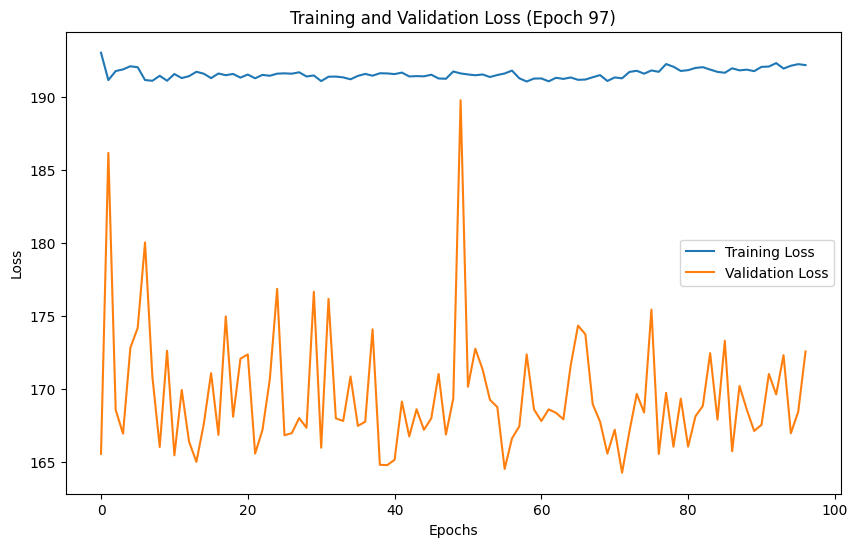

EarlyStopping counter: 25 out of 25
Early stopping


In [48]:
# same weights as LSTM, 4 weeks and two extra layers 
# 2023 split
model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=500)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

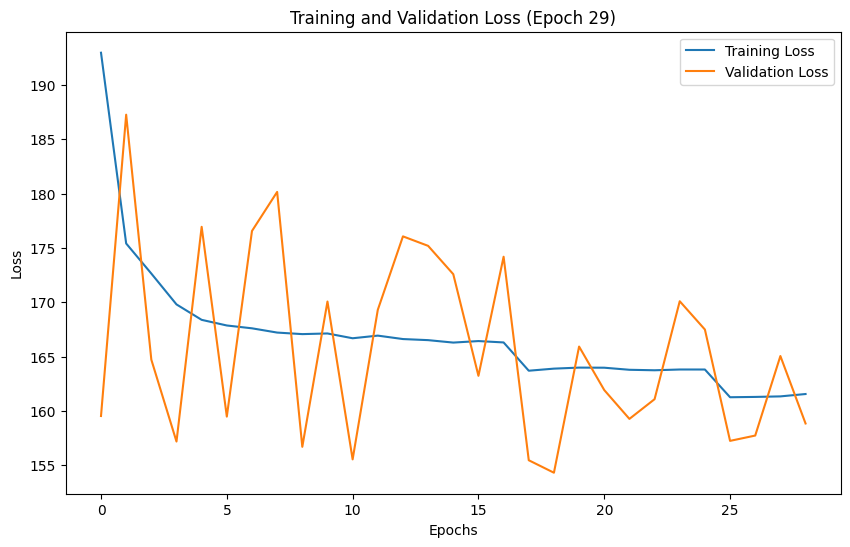

EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
# same weights as LSTM, 4 weeks and two extra layers 
# 2023 split
model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=500)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

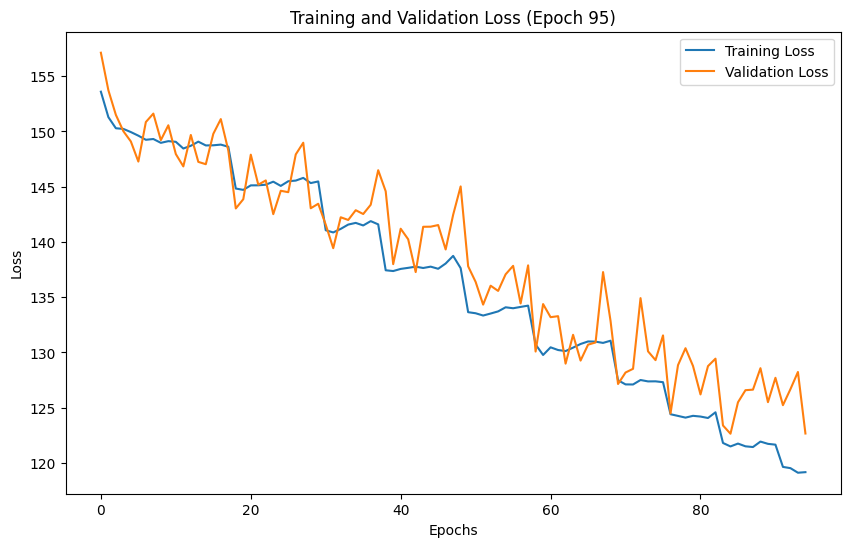

EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
# same weights as LSTM, 4 weeks and two extra layers
model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=500)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

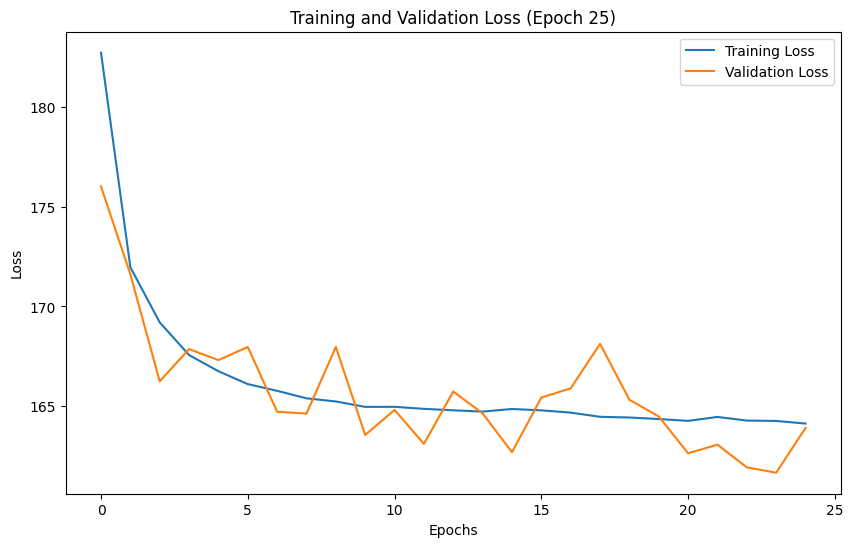

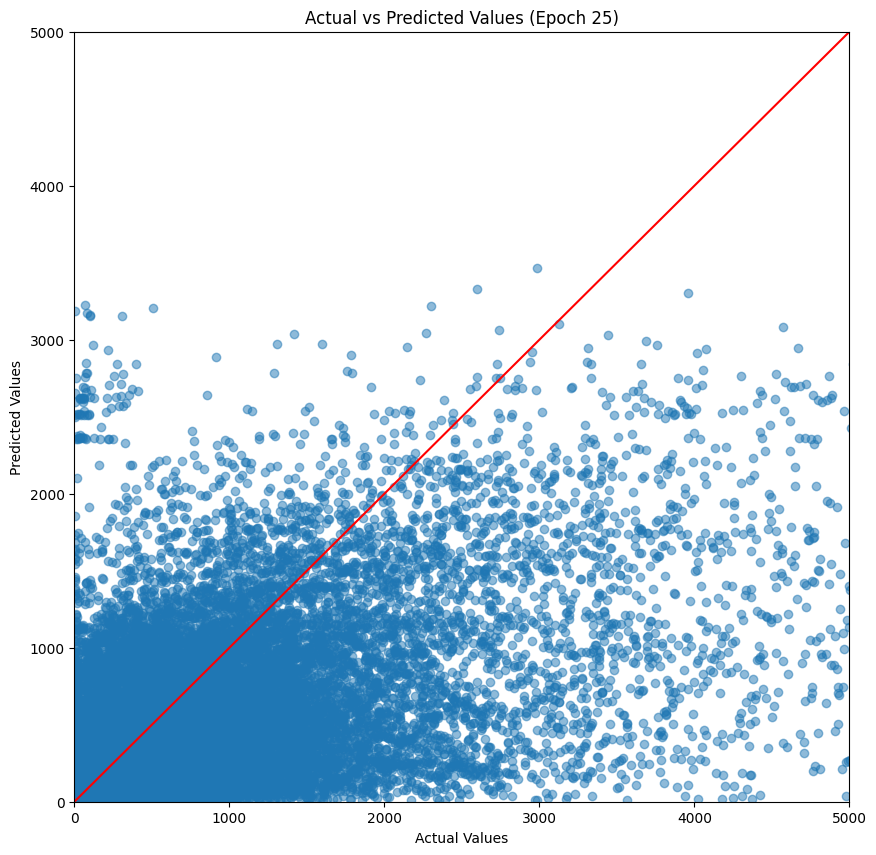

EarlyStopping counter: 1 out of 10
Epoch 25, Training Loss: 164.12885170953692, Validation Loss: 163.90931185610202


In [ ]:
# same weights as LSTM  and 4 weeks
#model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=25)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

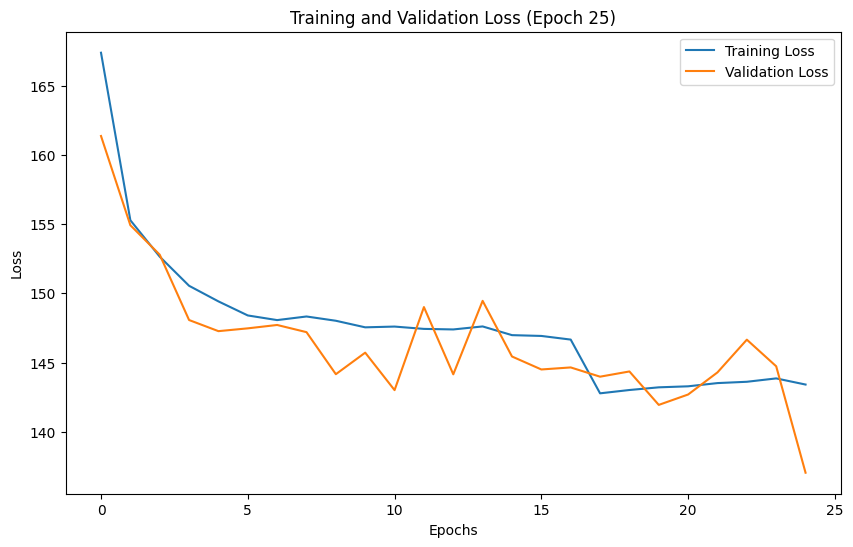

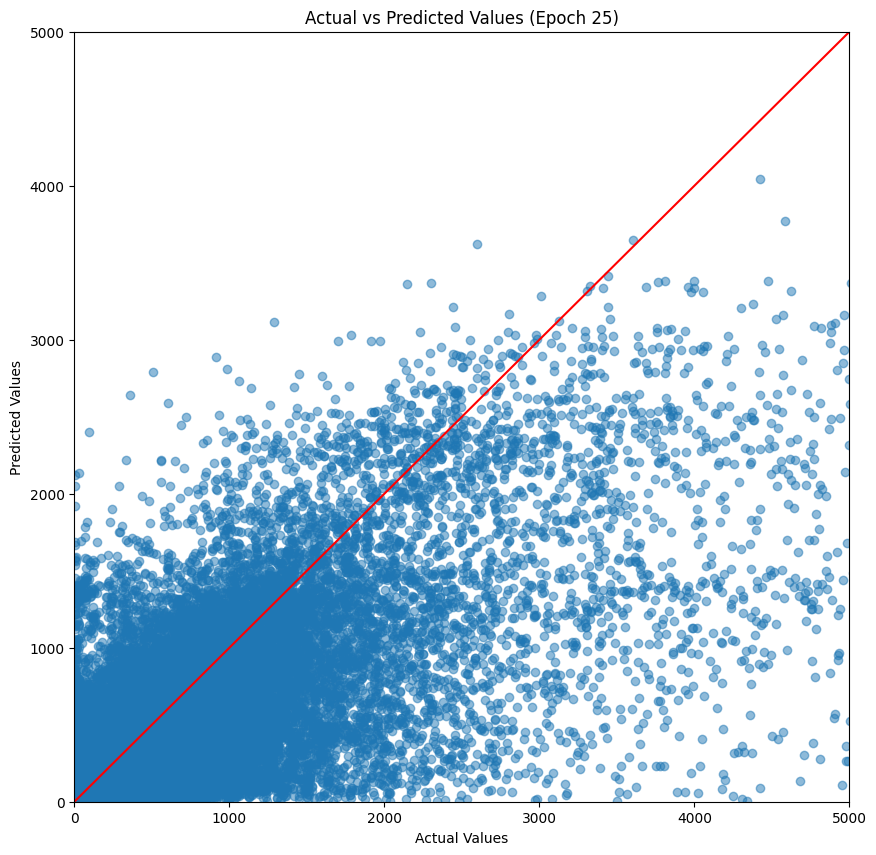

Validation loss decreased (141.943916 --> 137.046799).  Saving model ...
Epoch 25, Training Loss: 143.41315999068863, Validation Loss: 137.04679896057993


In [ ]:
# same weights as LSTM  and 1 week
#model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=25)#, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

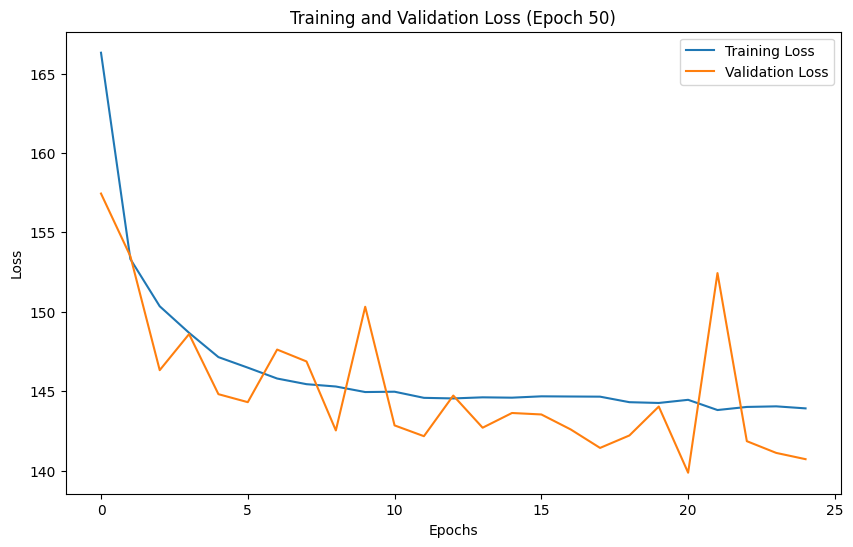

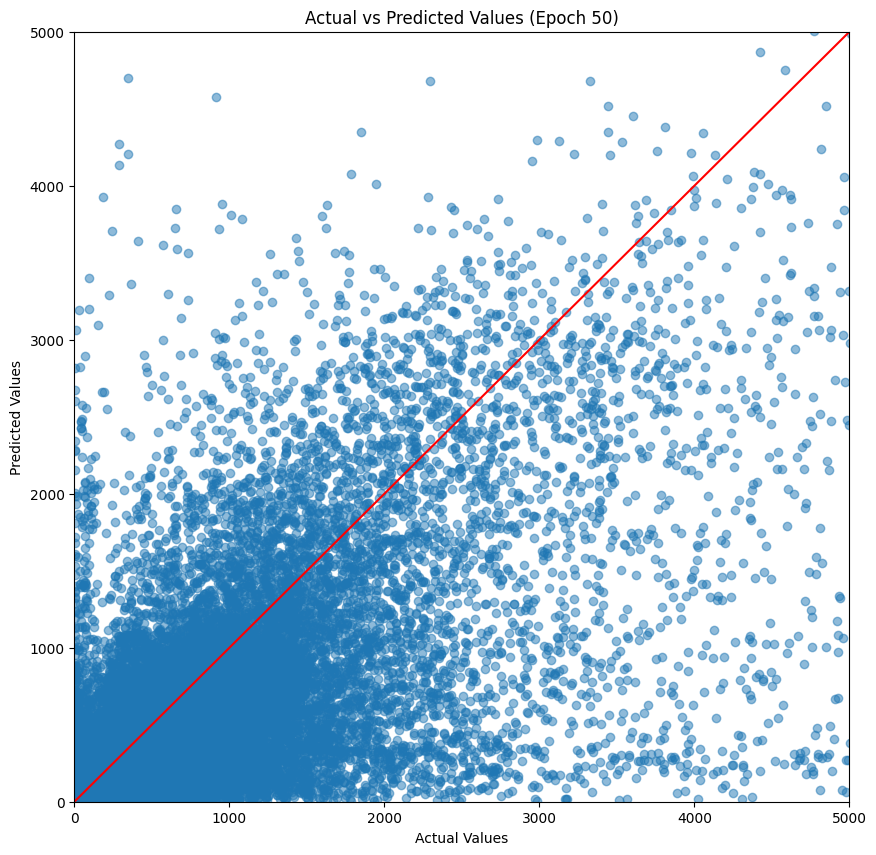

EarlyStopping counter: 4 out of 10
Epoch 50, Training Loss: 143.9126279367026, Validation Loss: 140.71371883427332


In [ ]:
# New

#model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 25, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=25, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

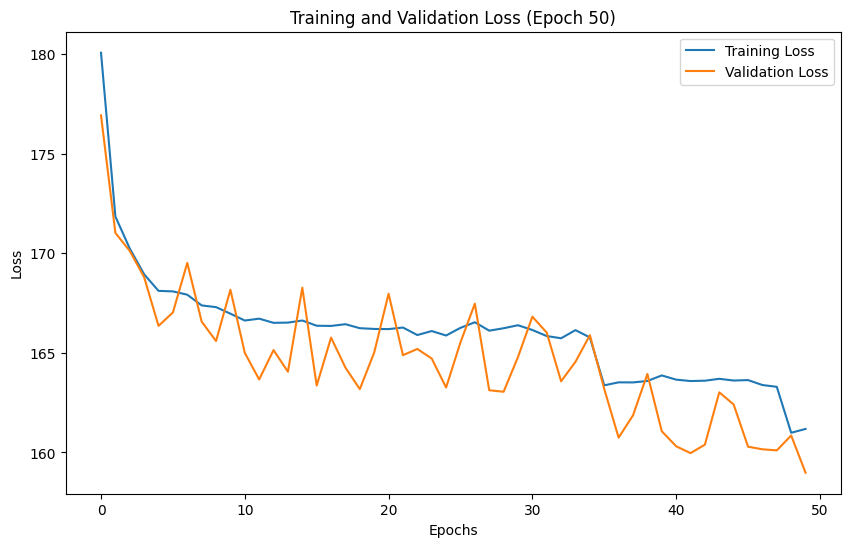

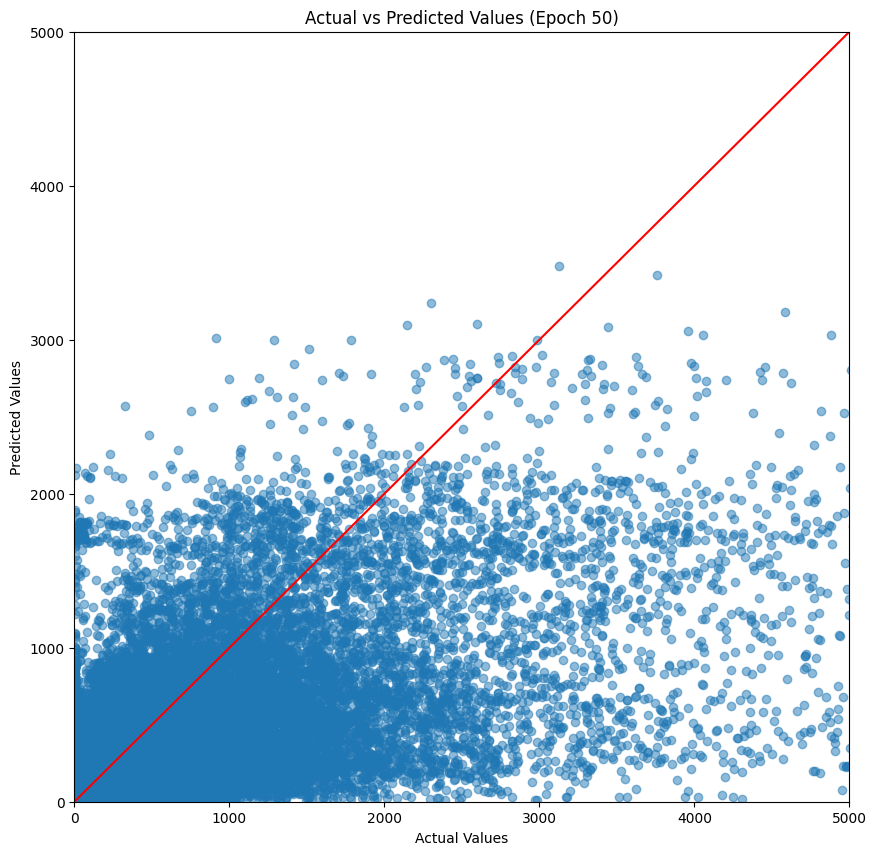

Validation loss decreased (159.961972 --> 158.978717).  Saving model ...
Epoch 50, Training Loss: 161.1791190098463, Validation Loss: 158.97871742534875


In [ ]:
#model_transformers, train_losses_transformers, val_losses_transformers = training_loop(model_type = "Transformers", model = model_transformers, extra_epoch = 25, train_loader = train_loader, test_loader = test_loader,val_loader = val_loader, epochs=25, train_losses = train_losses_transformers, val_losses = val_losses_transformers)

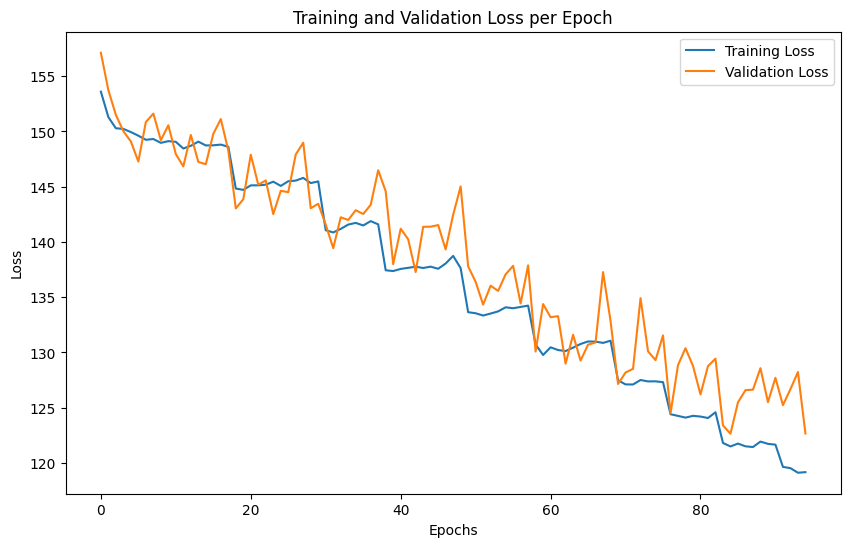

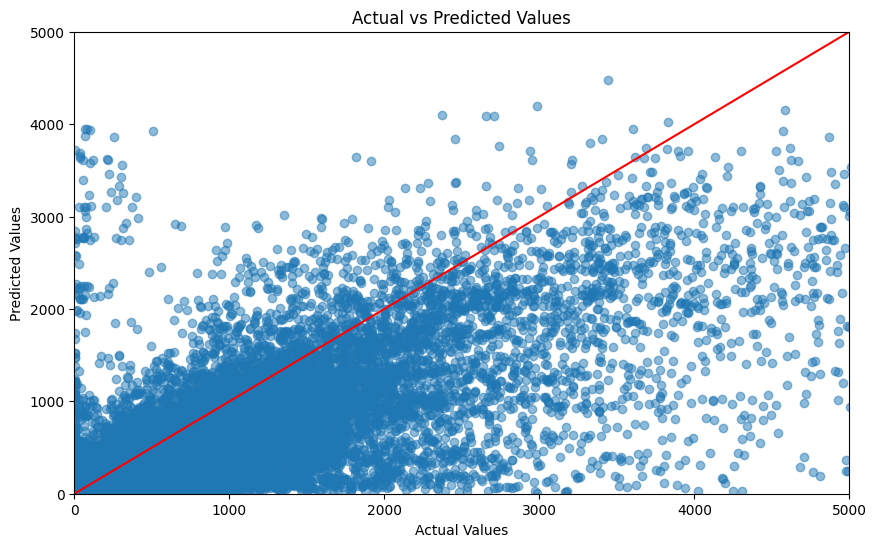

In [ ]:
actuals_transformers, predictions_transformers = plot_results(train_losses = train_losses_transformers, val_losses = val_losses_transformers, model_type = "Transformers", model = model_transformers)

In [ ]:
predictions_forecast_transformers, mae_transformers = validation(model_type = "Transformers", model = model_transformers, forecast_loader = forecast_loader, y_forecast = y_forecast)

NameError: name 'validation' is not defined

# LSTM

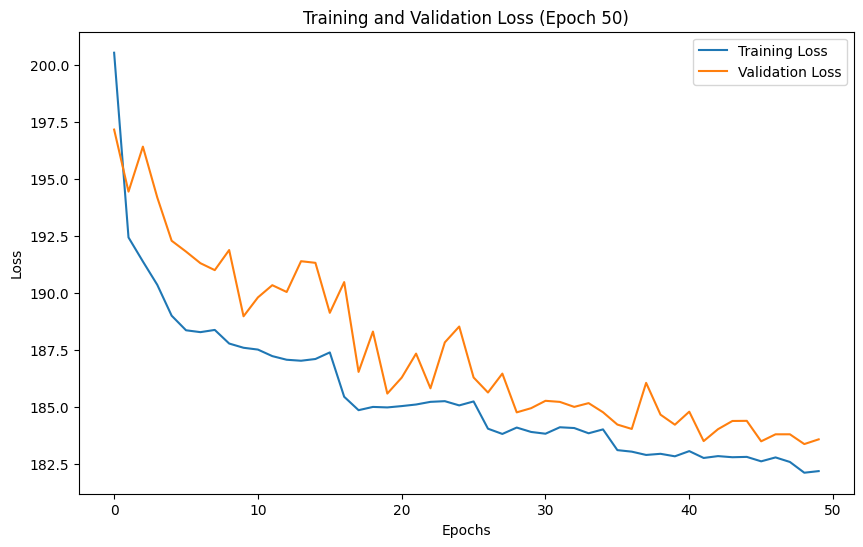

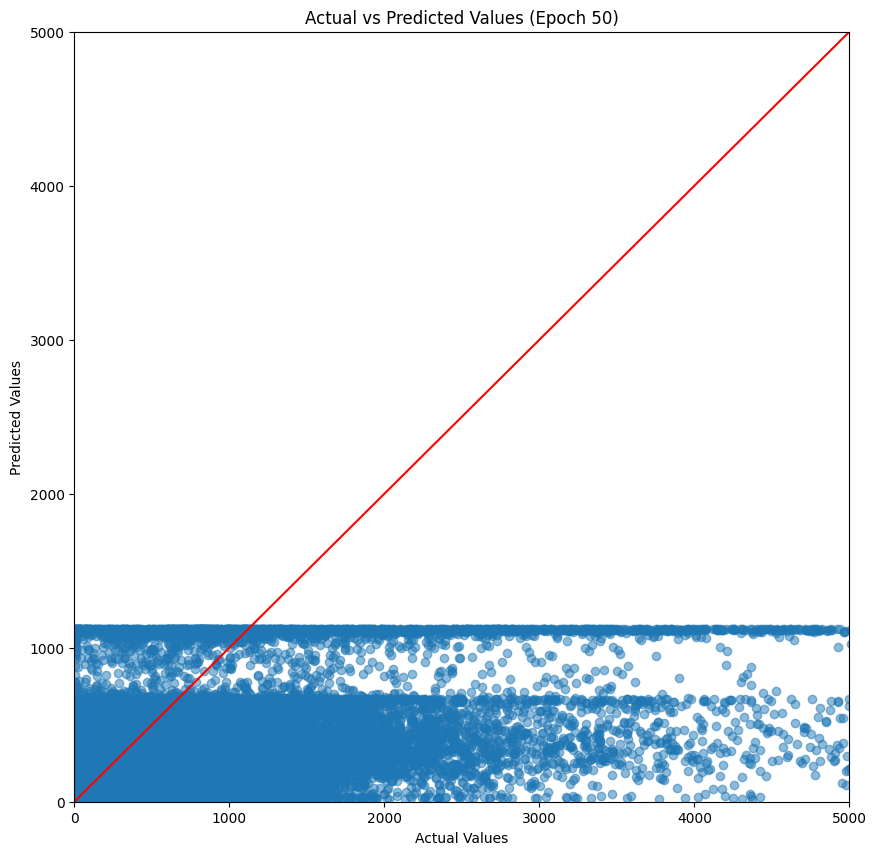

EarlyStopping counter: 1 out of 10
Epoch 50, Training Loss: 182.18596122719418, Validation Loss: 183.5800845517627


In [ ]:
model_LSTM, train_losses_LSTM, val_losses_LSTM = training_loop(model_type = "LSTM", model = model_LSTM, extra_epoch = 0, train_loader = train_loader, test_loader = test_loader, val_loader = val_loader, epochs=50)

In [ ]:
actuals_LSTM, predictions_LSTM = plot_results(train_losses = train_losses_LSTM, val_losses = val_losses_LSTM, model_type = "LSTM", model = model_LSTM)

NameError: name 'train_losses_LSTM' is not defined

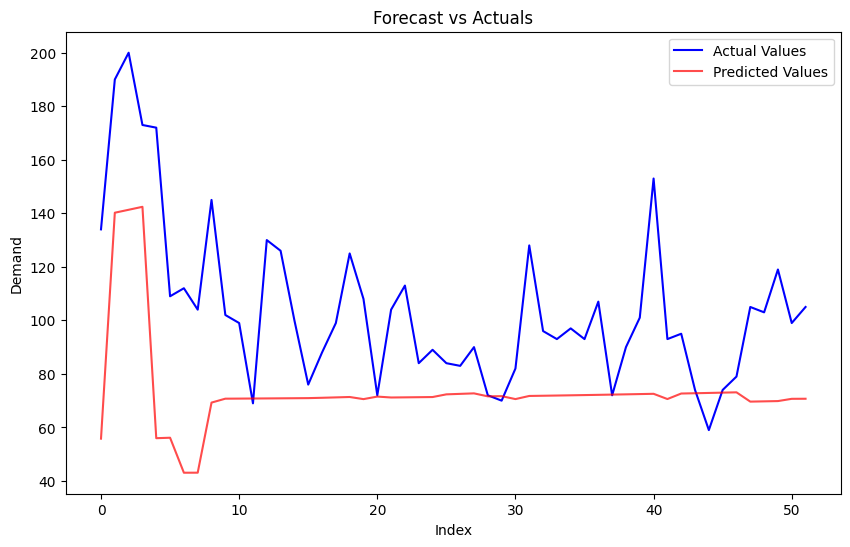

Mean Relative Error: 0.2734100119381935


In [ ]:
predictions_forecast_LSTM, mae_LSTM = validation(model_type = "LSTM", model = model_LSTM, forecast_loader = forecast_loader, y_forecast = y_forecast)

# ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=2739.450, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=2644.648, Time=1.12 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=2737.534, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[20] intercept   : AIC=2690.886, Time=0.18 sec
 ARIMA(1,0,0)(2,1,0)[20] intercept   : AIC=2619.865, Time=2.51 sec
 ARIMA(1,0,0)(2,1,1)[20] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(0,0,0)(2,1,0)[20] intercept   : AIC=2664.860, Time=2.44 sec
 ARIMA(2,0,0)(2,1,0)[20] intercept   : AIC=2621.493, Time=4.13 sec
 ARIMA(1,0,1)(2,1,0)[20] intercept   : AIC=2620.996, Time=4.94 sec
 ARIMA(0,0,1)(2,1,0)[20] intercept   : AIC=2628.704, Time=2.90 sec
 ARIMA(2,0,1)(2,1,0)[20] intercept   : AIC=2621.237, Time=5.52 sec
 ARIMA(1,0,0)(2,1,0)[20]             : 

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

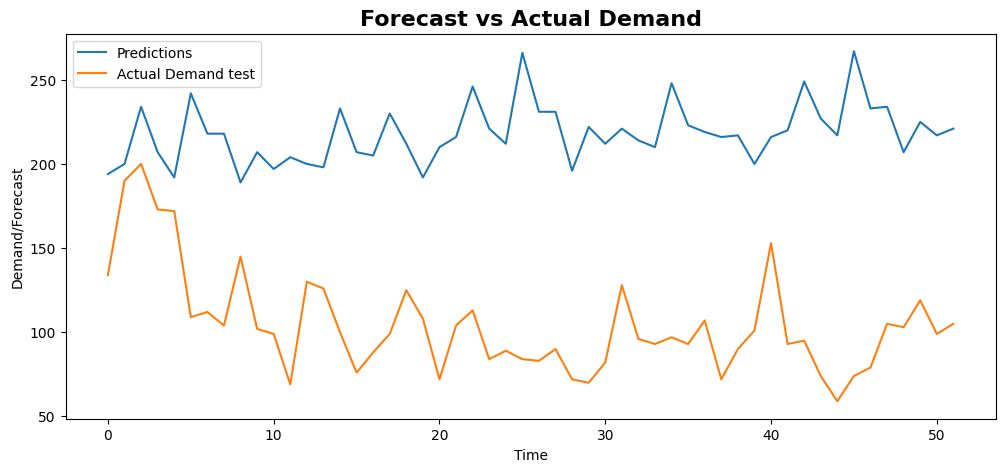

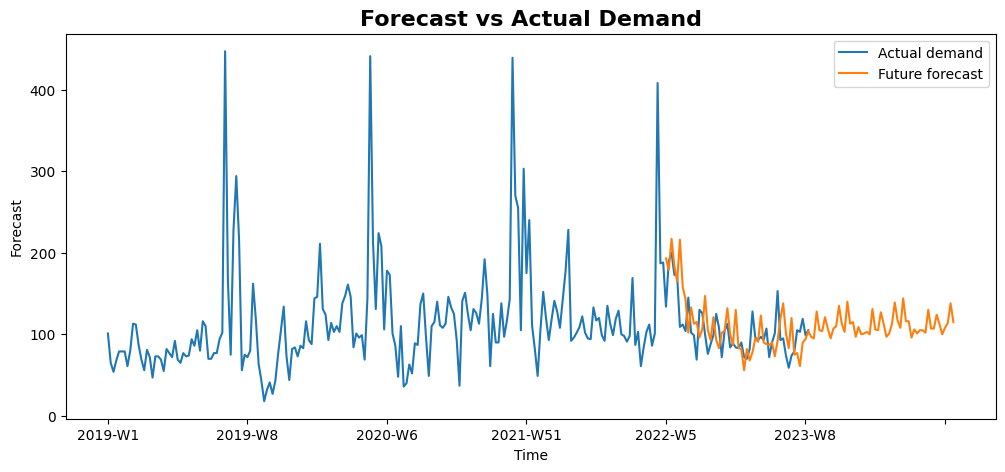

Mean Relative Error: 1.2447679978383026


In [ ]:
predictions_forecast_ARIMA, mae_ARIMA = ARIMA()

# Comparison

In [ ]:
random.seed(42)
Forecast_pandora = []
for value in y_forecast.values:
    Forecast_pandora.append(value * 0.95 * random.random())

Forecast_pandora_series = pd.Series(Forecast_pandora, index=index)

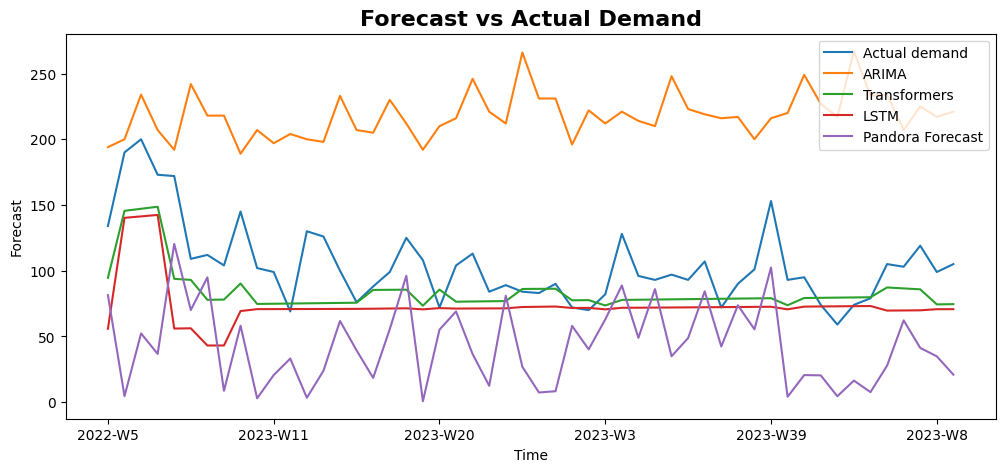

In [ ]:
index = y_forecast.index

# Convert lists to Pandas Series
predictions_forecast_transformers_series = pd.Series(predictions_forecast_transformers, index=index)
predictions_forecast_LSTM_series = pd.Series(predictions_forecast_LSTM, index=index)

# Now plot using Pandas plot function
plt.figure(figsize=(12, 5))
y_forecast.plot(legend=True, label="Actual demand")
predictions_forecast_ARIMA.reset_index(drop=True).plot(label="ARIMA")
predictions_forecast_transformers_series.reset_index(drop=True).plot(label="Transformers")
predictions_forecast_LSTM_series.reset_index(drop=True).plot(label="LSTM")
Forecast_pandora_series.plot(label="Pandora Forecast")
plt.title("Forecast vs Actual Demand", fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Forecast')
plt.show()

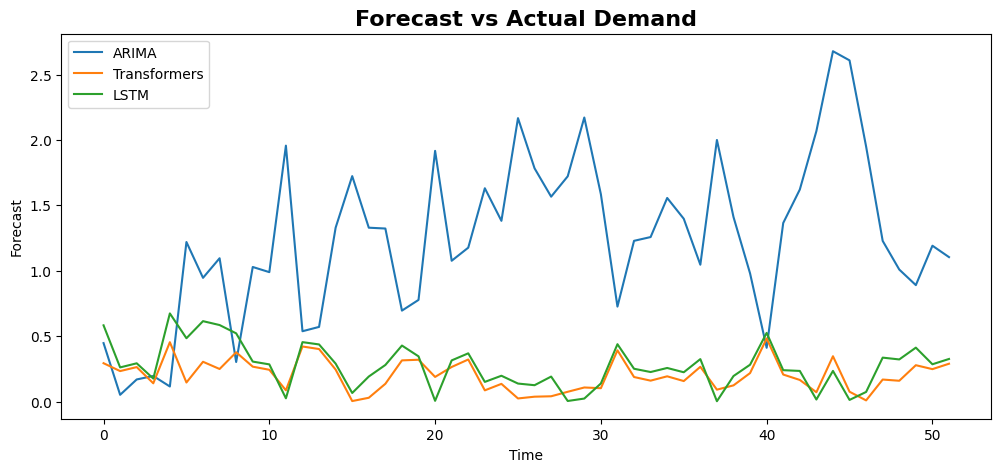

In [ ]:
# Difference

ARIMA_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_ARIMA.reset_index(drop=True))/y_forecast.reset_index(drop=True)
Transformers_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_transformers_series.reset_index(drop=True))/y_forecast.reset_index(drop=True)
LSTM_diff = (y_forecast.reset_index(drop=True) - predictions_forecast_LSTM_series.reset_index(drop=True))/y_forecast.reset_index(drop=True)

# Plot difference series
plt.figure(figsize=(12, 5))
ARIMA_diff.abs().plot(label="ARIMA")
Transformers_diff.abs().plot(label="Transformers")
LSTM_diff.abs().plot(label="LSTM")
plt.title("Forecast vs Actual Demand", fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Forecast')
plt.show()

# Category evaluation

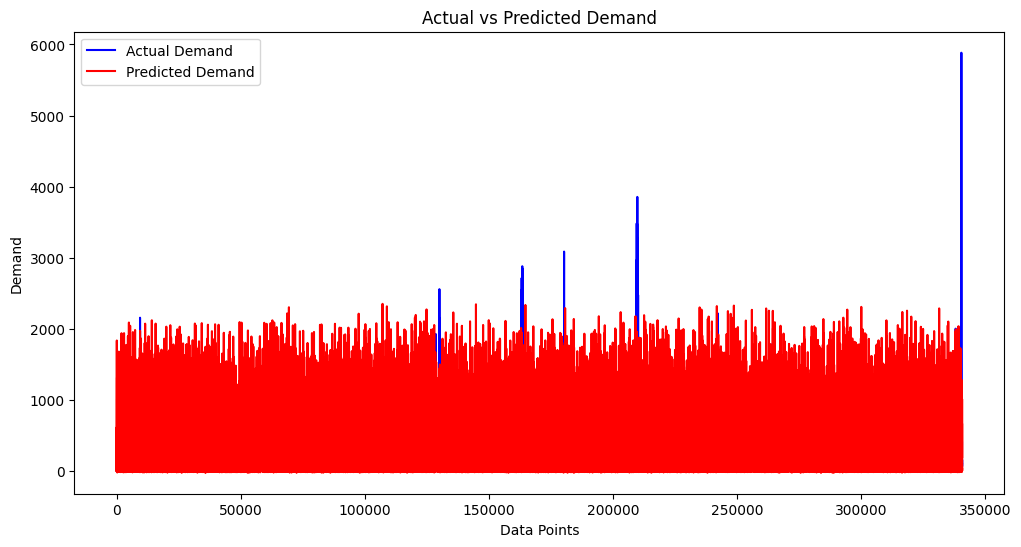

Mean Relative Error: 20.788820530950915


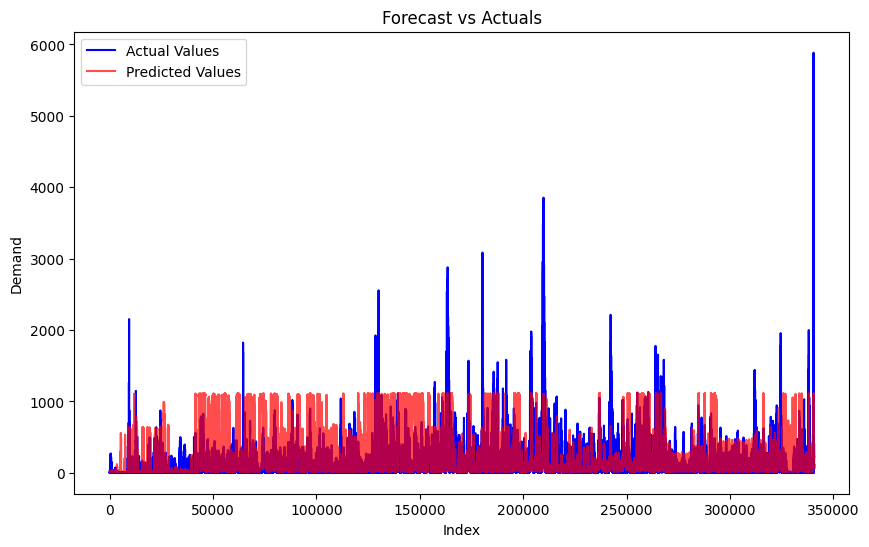

Mean Relative Error: 12.786506662121774


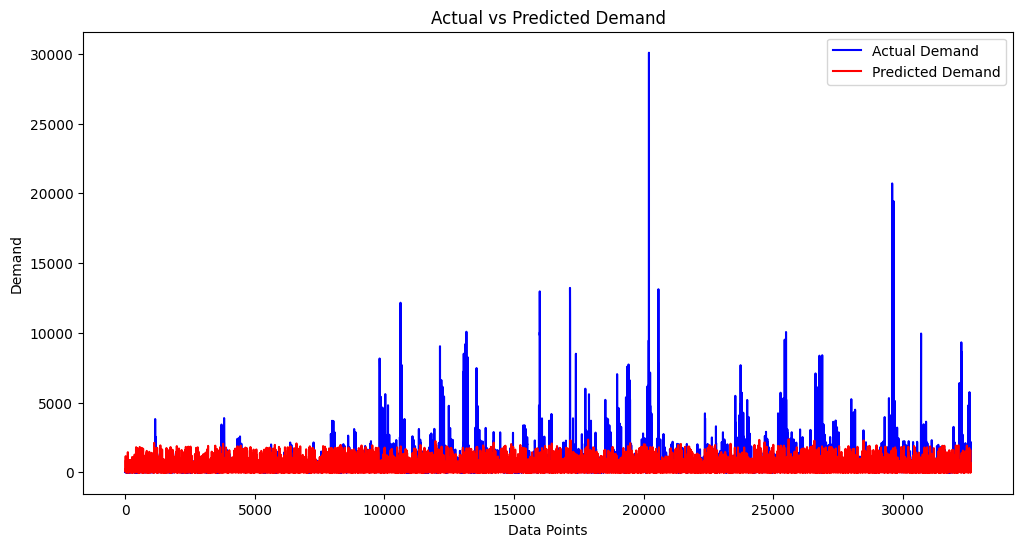

Mean Relative Error: 17.318940524133282


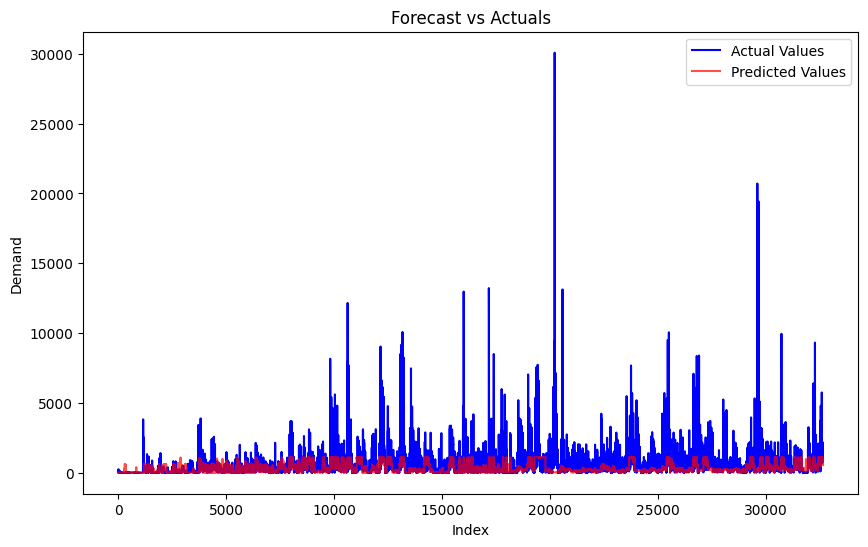

Mean Relative Error: 5.3997590060503065


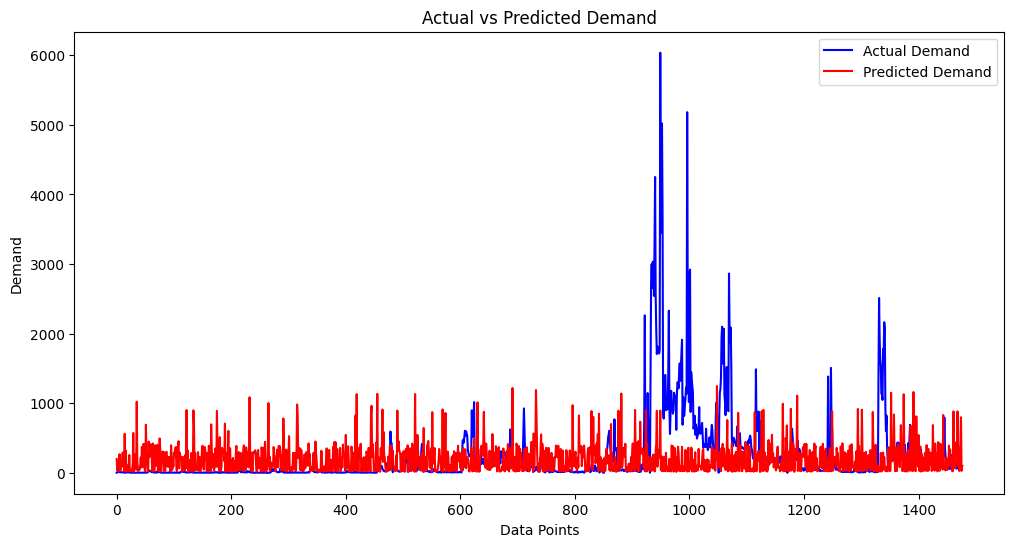

Mean Relative Error: 25.40984115440549


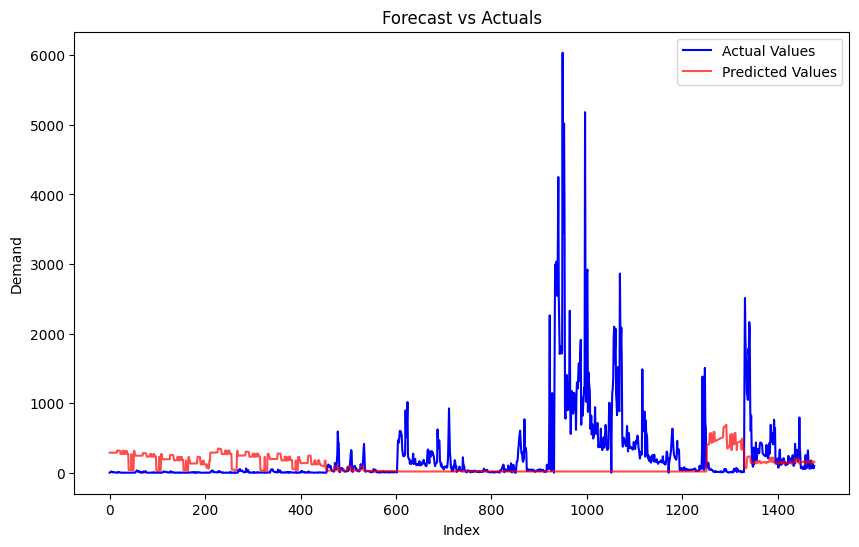

Mean Relative Error: 22.44821004179709


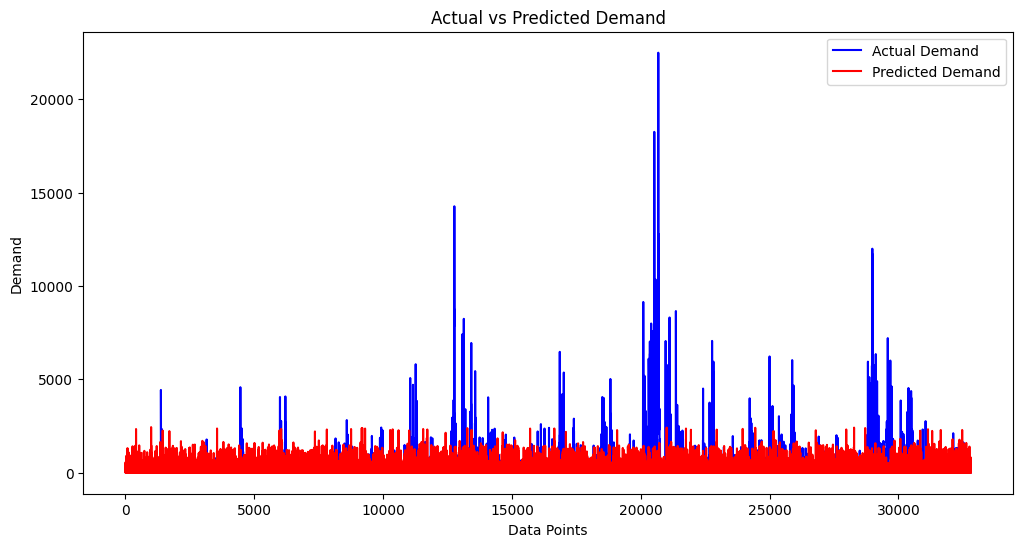

Mean Relative Error: 13.366464230296797


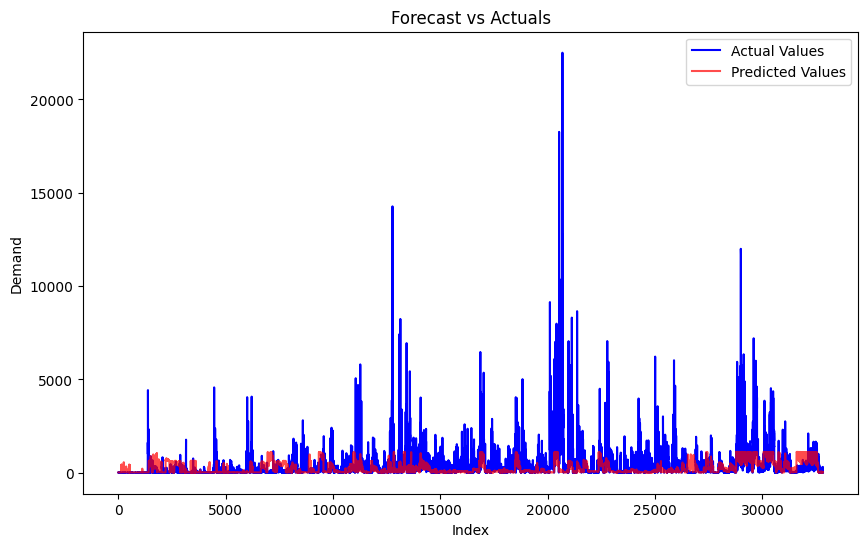

Mean Relative Error: 8.808605615686055


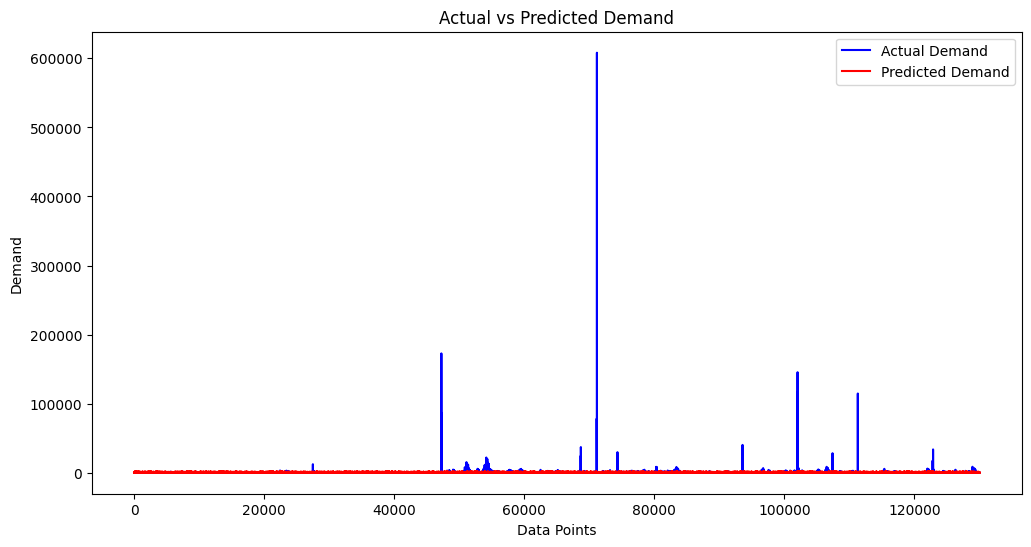

Mean Relative Error: 16.435539550889505


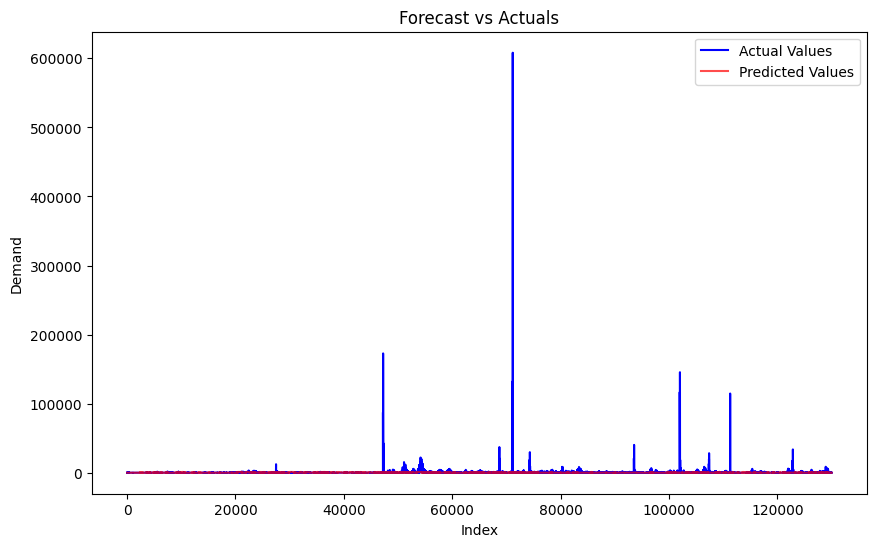

Mean Relative Error: 16.854855412776413


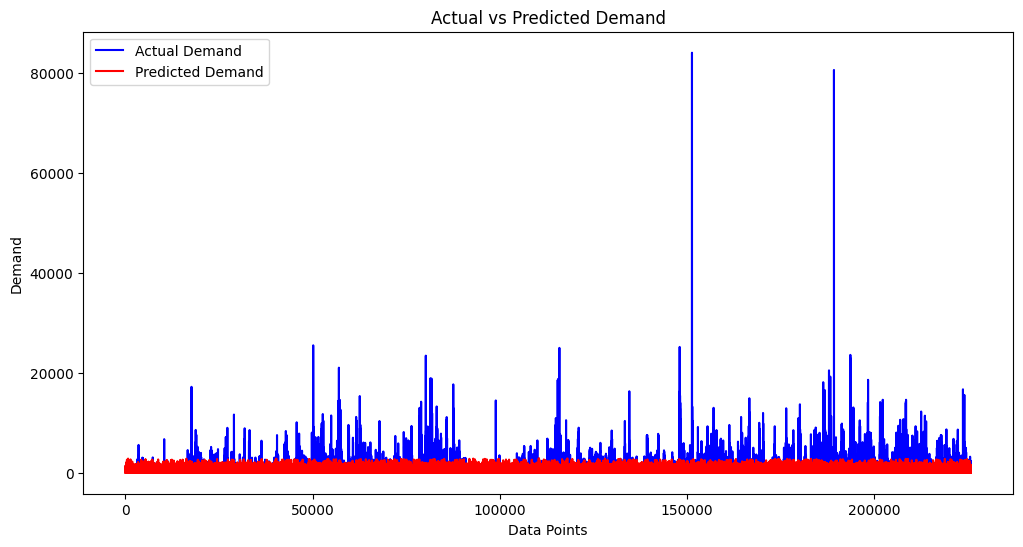

Mean Relative Error: 13.491899400245059


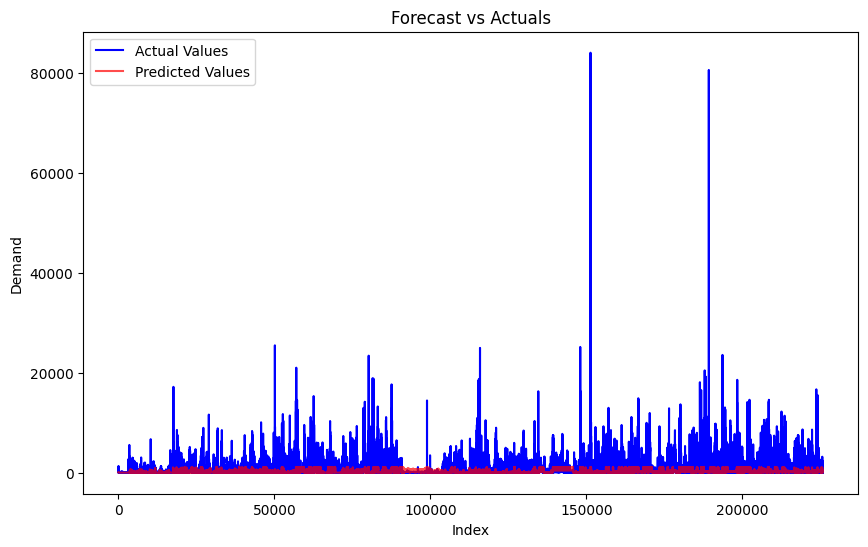

Mean Relative Error: 6.262815898022777


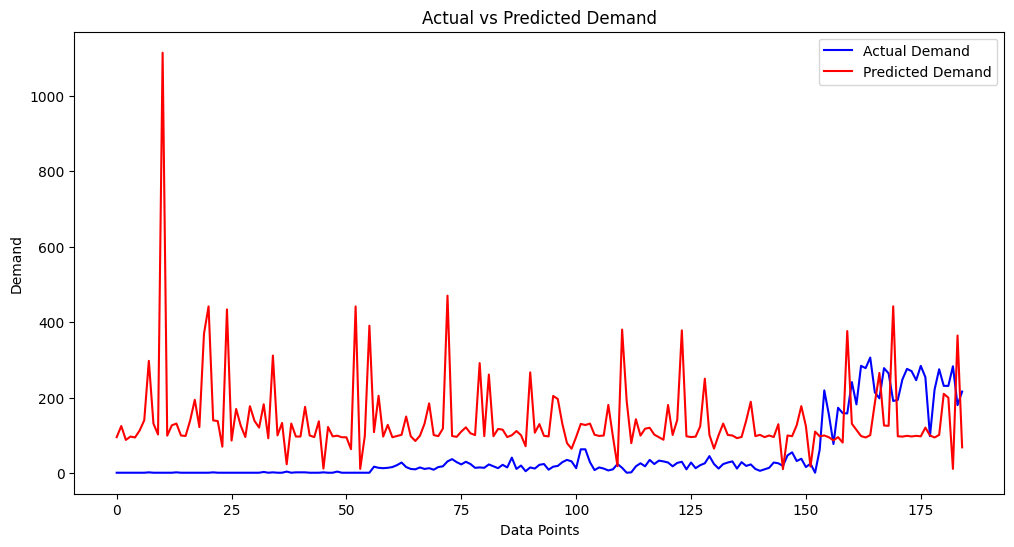

Mean Relative Error: 49.472033387378424


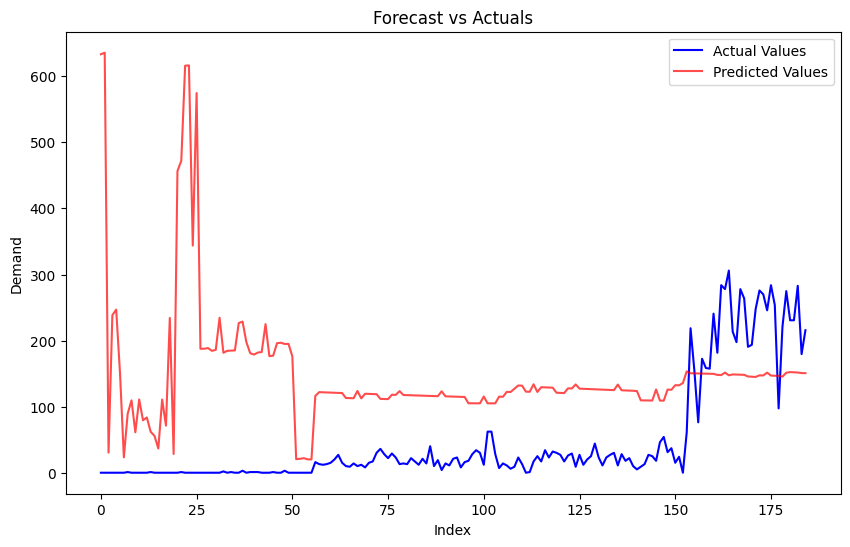

Mean Relative Error: 58.14945200002899


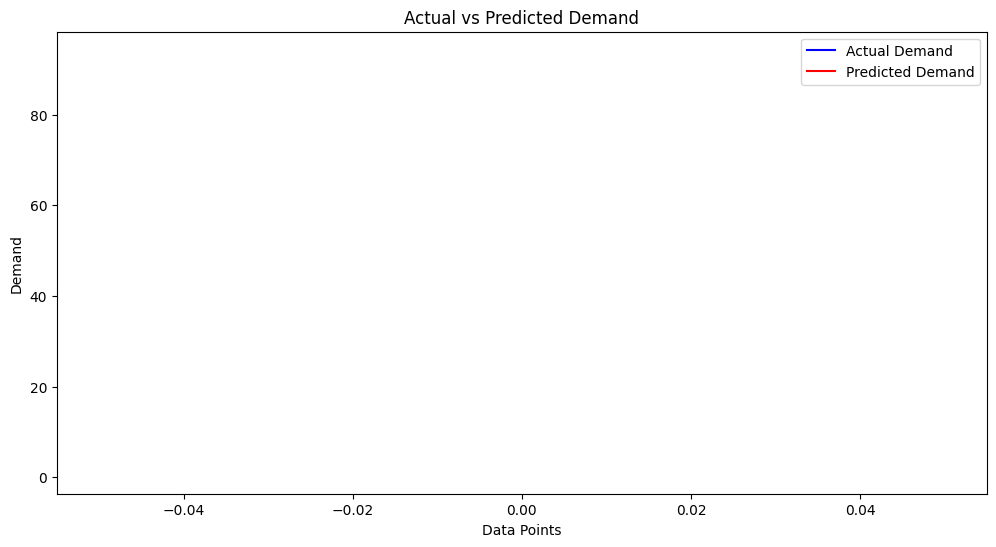

Mean Relative Error: 92.64321899414062


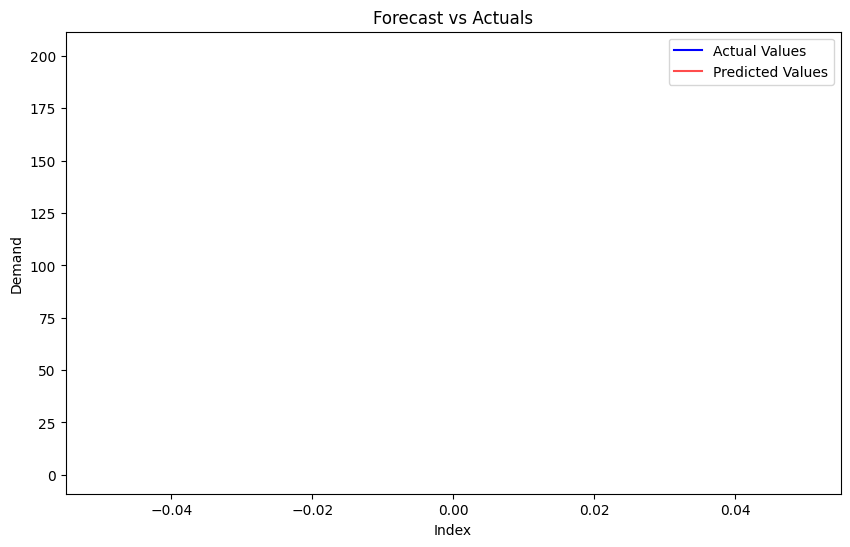

Mean Relative Error: 200.5519256591797


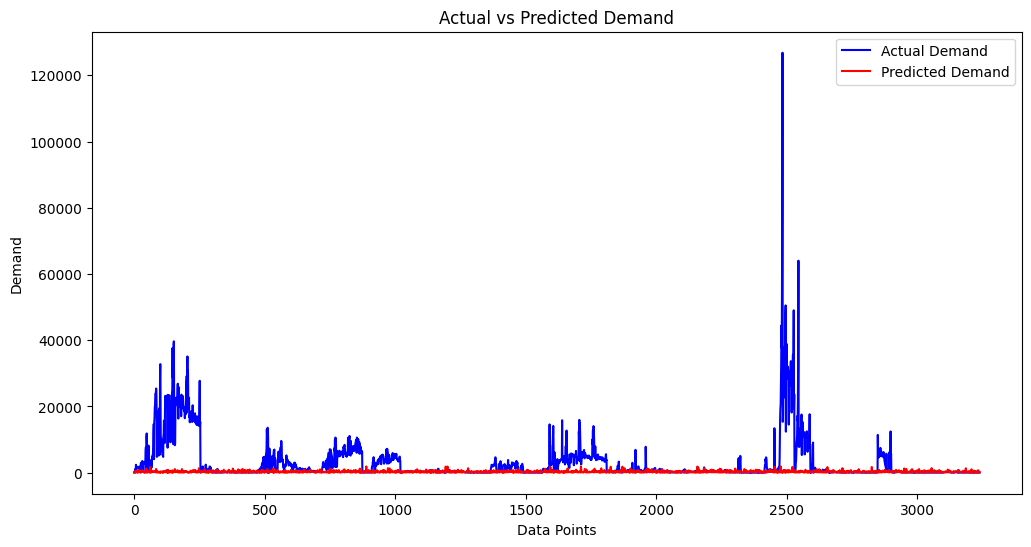

Mean Relative Error: 14.169981536179128


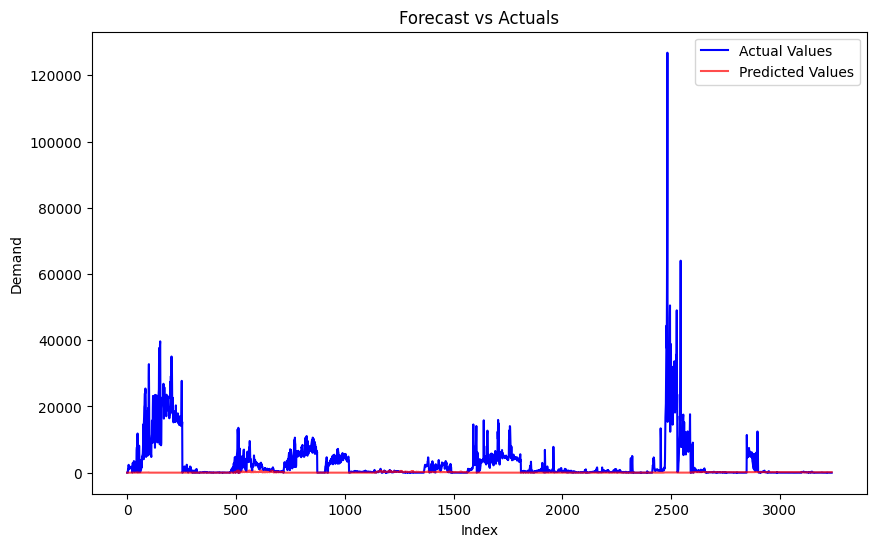

Mean Relative Error: 5.849602859692915


In [ ]:
combined_df2 = pd.concat([data_num, forecast_num])

categories = {}

for category, group in combined_df2.groupby('DNA Category '):
        
        categories[category] = {}

        X = group.drop(columns=['Demand'])
        y = group['Demand']

        X_scaled = scaler.fit_transform(X)

        # Convert to PyTorch tensors
        X_tensor_transformers = torch.tensor(X_scaled, dtype=torch.float32)
        y_tensor_transformers = torch.tensor(y.values, dtype=torch.float32)

        ##
        X_tensor_LSTM = torch.tensor(X_scaled.astype(np.float32))
        y_tensor_LSTM = torch.tensor(y.values.astype(np.float32))
        ##

        # Create Data Loaders
        data_transformers = TensorDataset(X_tensor_transformers, y_tensor_transformers)
        #
        data_LSTM = TensorDataset(X_tensor_LSTM, y_tensor_LSTM)
        #

        loader_transformers = DataLoader(data_transformers, batch_size=128, shuffle=True)
        #
        loader_LSTM = DataLoader(data_LSTM, batch_size=128)
        #


        predictions_forecast_transformers_category, mre_transformers_category = validation(model_type="Transformers",model=model_transformers,forecast_loader=loader_transformers,y_forecast=y)
        predictions_forecast_LSTM_category, mre_LSTM_category = validation(model_type="LSTM",model=model_LSTM,forecast_loader=loader_LSTM,y_forecast=y)
        
        categories[category]["Transformers"] = [predictions_forecast_transformers_category, mre_transformers_category]
        categories[category]["LSTM"] = [predictions_forecast_LSTM_category, mre_LSTM_category]
        

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=276.066, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=288.356, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=275.430, Time=0.47 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=273.802, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=287.933, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[20] intercept   : AIC=282.580, Time=0.07 sec
 ARIMA(0,0,1)(1,1,1)[20] intercept   : AIC=275.673, Time=0.66 sec
 ARIMA(0,0,1)(0,1,2)[20] intercept   : AIC=275.673, Time=0.92 sec
 ARIMA(0,0,1)(1,1,0)[20] intercept   : AIC=275.064, Time=0.31 sec
 ARIMA(0,0,1)(1,1,2)[20] intercept   : AIC=277.673, Time=0.98 sec
 ARIMA(0,0,0)(0,1,1)[20] intercept   : AIC=278.212, Time=0.35 sec
 ARIMA(0,0,2)(0,1,1)[20] intercept   : AIC=275.513, Time=0.60 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=274.152, Time=0.41 sec
 ARIMA(1,0,2)(0,1,1)[20] intercept   : AIC=277.273, Time=1.06 sec
 ARIMA(0,0,1)(0,1,1)[20]         

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

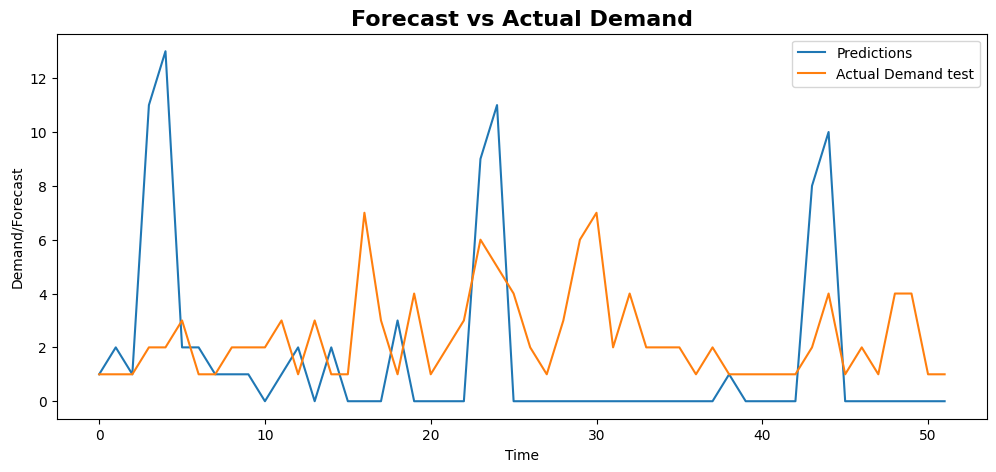

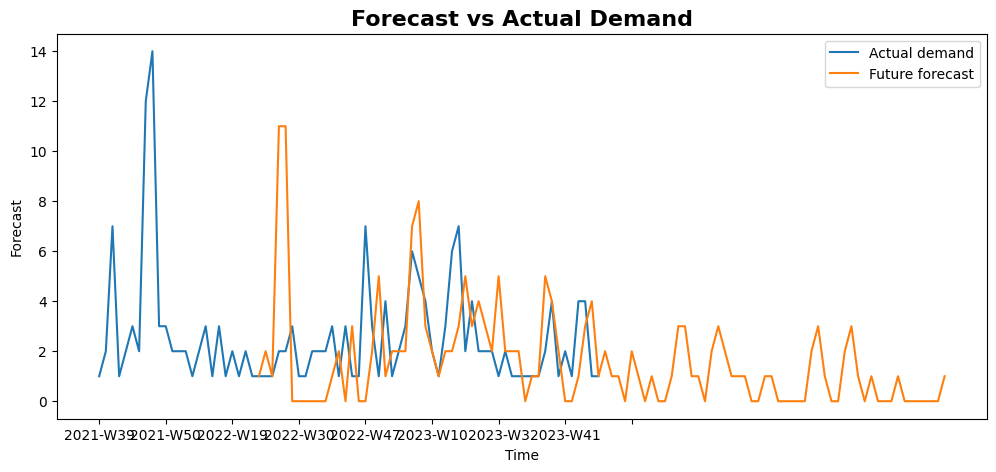

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=309.926, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=313.511, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=315.226, Time=0.30 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=310.828, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=313.164, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[20] intercept   : AIC=315.206, Time=0.11 sec
 ARIMA(1,0,1)(1,1,1)[20] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(1,0,1)(0,1,2)[20] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(1,0,1)(1,1,0)[20] intercept   : AIC=313.978, Time=0.55 sec
 ARIMA(1,0,1)(1,1,2)[20] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,1)(0,1,1)[20] intercept   : AIC=309.471, Time=0.62 sec
 ARIMA(2,0,1)(0,1,0)[20] intercept   : AIC=313.414, Time=0.15 sec
 ARIMA(2,0,1)(1,1,1)[20] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(2,0,1)(0,1,2)[20] intercept   : AIC=inf, Time=

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

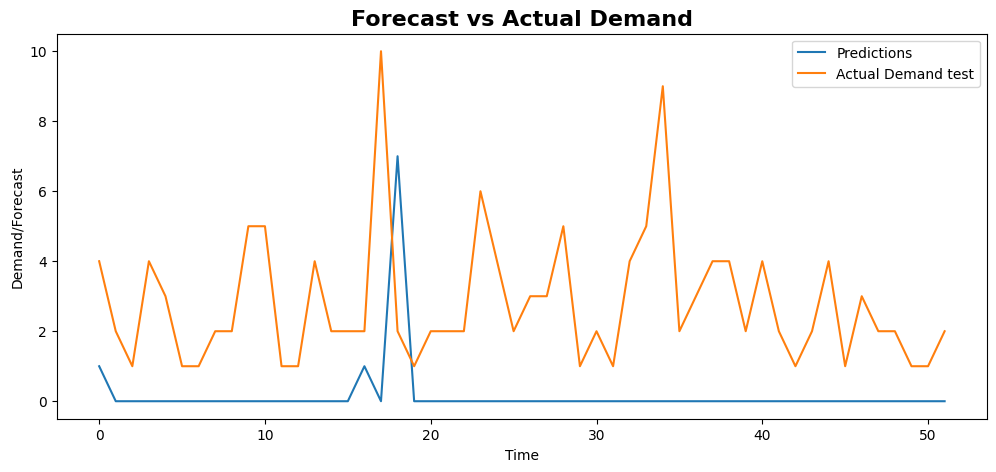

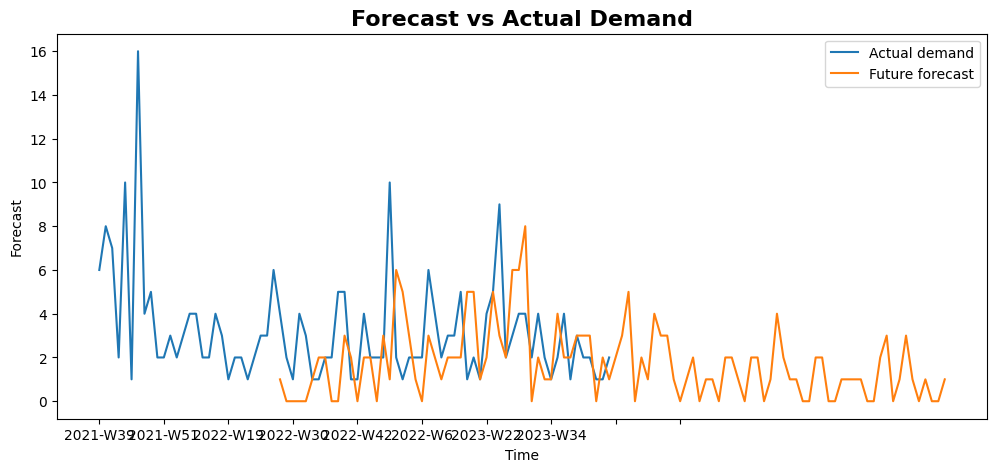

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=598.406, Time=0.73 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=622.082, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=609.480, Time=0.45 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=626.793, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[20] intercept   : AIC=610.206, Time=0.12 sec
 ARIMA(1,0,1)(1,1,1)[20] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,0,1)(0,1,2)[20] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(1,1,0)[20] intercept   : AIC=604.848, Time=0.63 sec
 ARIMA(1,0,1)(1,1,2)[20] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(2,0,1)(0,1,1)[20] intercept   : AIC=600.405, Time=1.59 sec
 ARIMA(1,0,2)(0,1,1)[20] intercept   : AIC=600.405, Time=0.96 sec
 ARIMA(0,0,0)(0,1,1)[20] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,2)(0,1,1)[20] intercept   : AIC=inf, Time=0.87

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

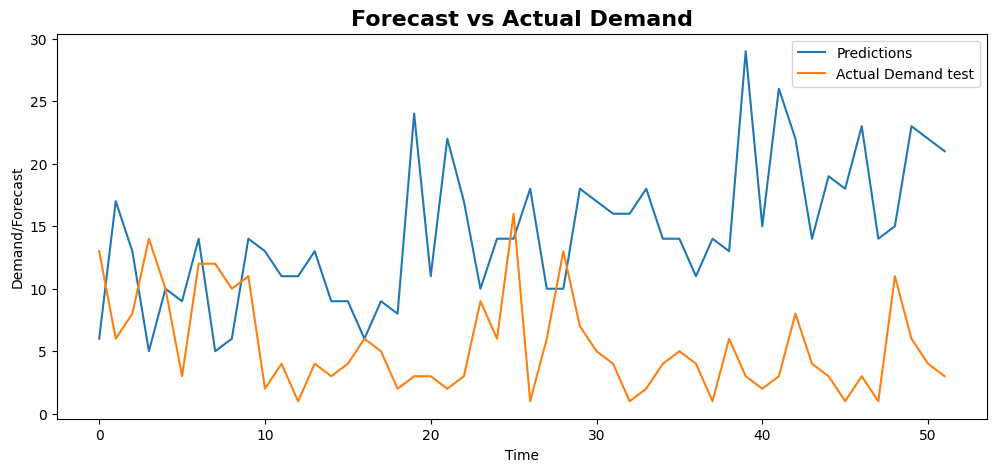

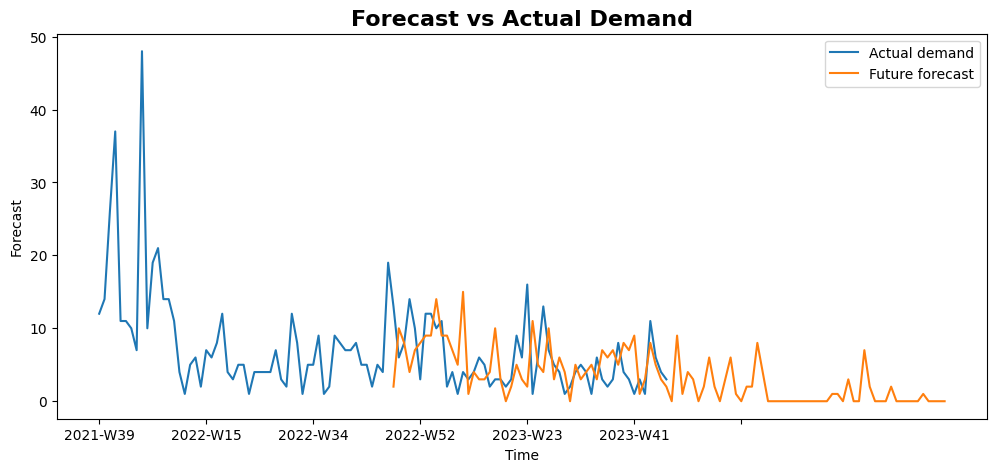

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=721.513, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=749.741, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=731.481, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=721.758, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[20]             : AIC=729.926, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[20]             : AIC=723.317, Time=0.73 sec
 ARIMA(1,1,1)(0,1,2)[20]             : AIC=723.195, Time=1.23 sec
 ARIMA(1,1,1)(1,1,0)[20]             : AIC=723.765, Time=0.45 sec
 ARIMA(1,1,1)(1,1,2)[20]             : AIC=inf, Time=3.34 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=730.344, Time=0.37 sec
 ARIMA(2,1,1)(0,1,1)[20]             : AIC=723.379, Time=0.79 sec
 ARIMA(1,1,2)(0,1,1)[20]             : AIC=723.392, Time=0.80 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=738.423, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=721.409, Time=0.47 sec
 ARIMA(0,1,2)(0,1,0)[20]             

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

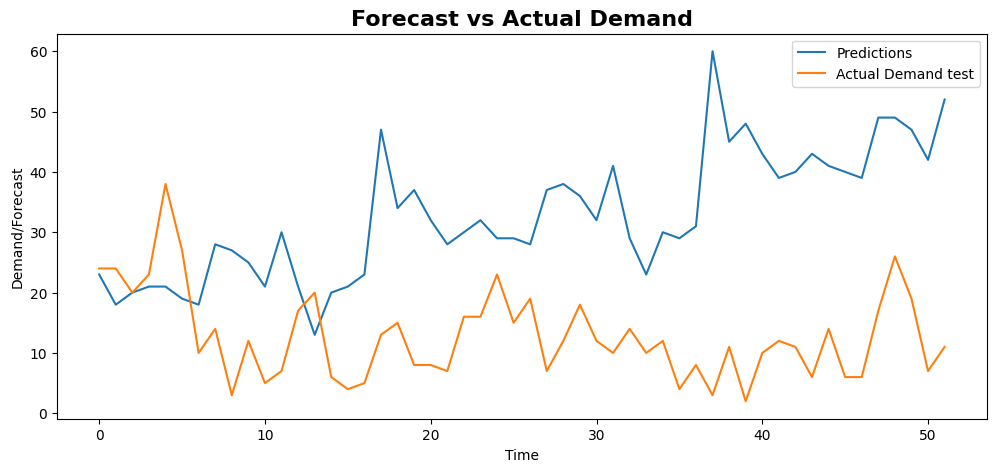

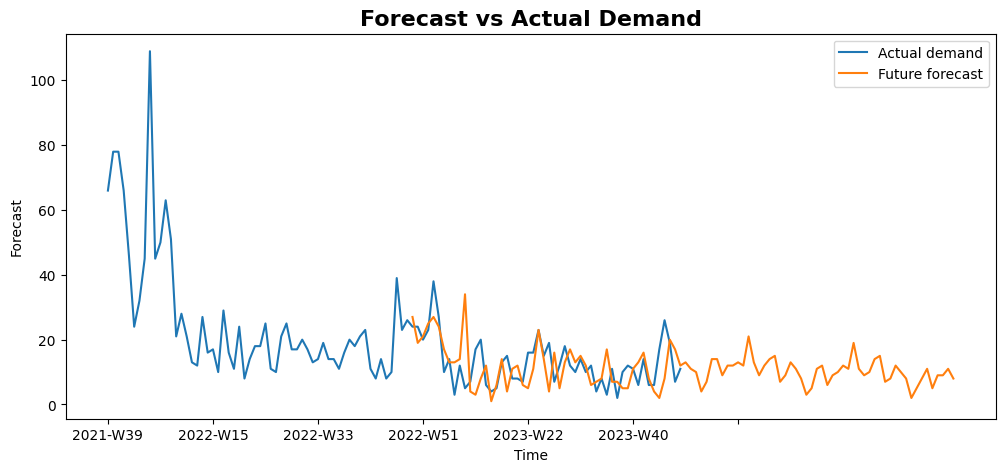

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=805.855, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=836.531, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=805.780, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=804.399, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[20]             : AIC=816.779, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=805.971, Time=0.67 sec
 ARIMA(0,1,1)(0,1,2)[20]             : AIC=805.903, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=806.343, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[20]             : AIC=inf, Time=3.34 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=818.510, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=806.399, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=803.886, Time=0.46 sec
 ARIMA(1,1,0)(0,1,0)[20]             : AIC=816.054, Time=0.06 sec
 ARIMA(1,1,0)(1,1,1)[20]             : AIC=805.496, Time=0.61 sec
 ARIMA(1,1,0)(0,1,2)[20]             

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

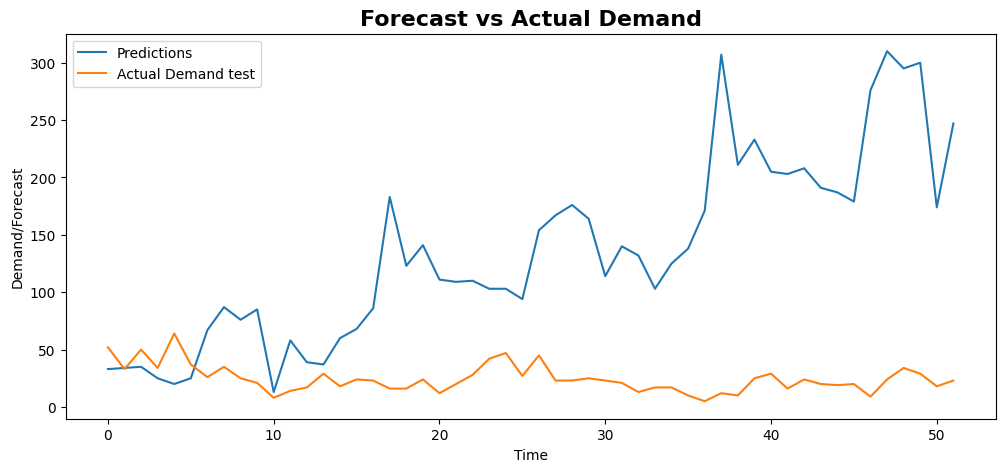

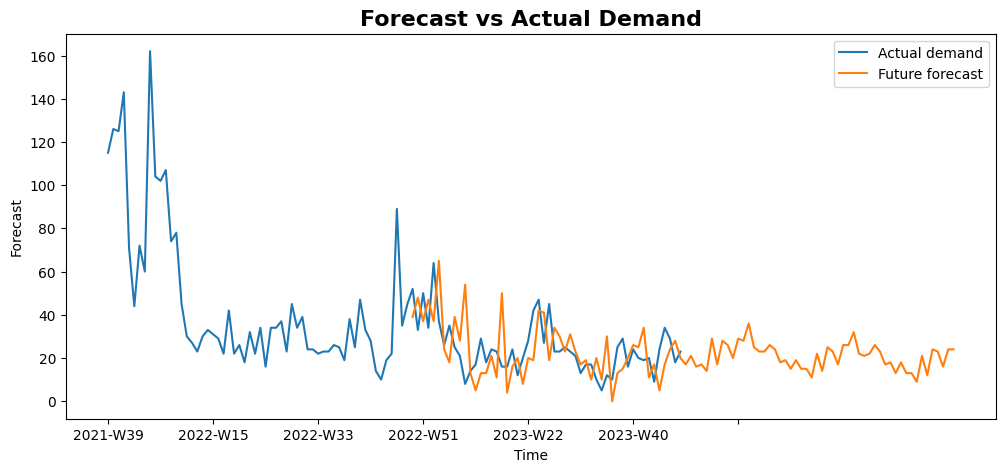

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=901.352, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=931.325, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=903.123, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=899.368, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[20]             : AIC=905.641, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=901.364, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[20]             : AIC=901.362, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=901.964, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[20]             : AIC=903.255, Time=1.61 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=918.807, Time=0.43 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=901.363, Time=0.56 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=900.997, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[20]             : AIC=903.157, Time=0.86 sec
 ARIMA(0,1,1)(0,1,1)[20] intercept   : AIC=900.067, Time=0.63 sec

Best model:  ARIMA(0,1,1)(0,1,1)

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

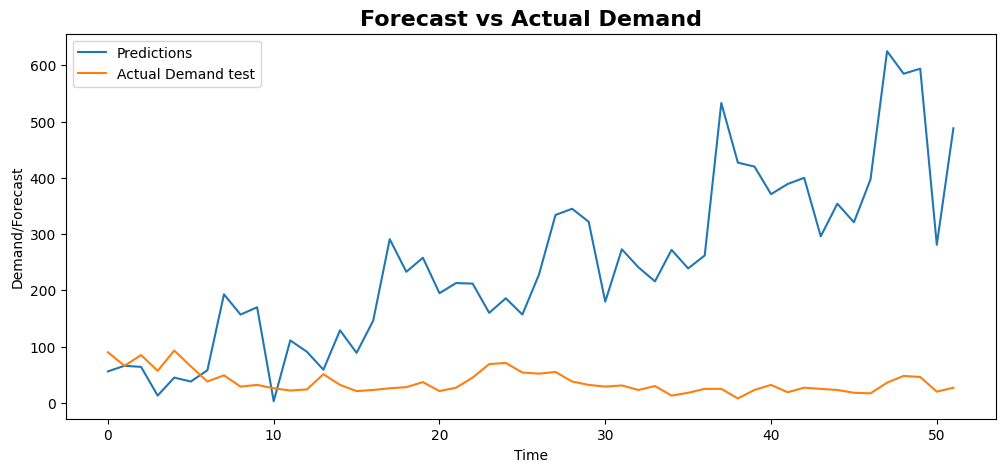

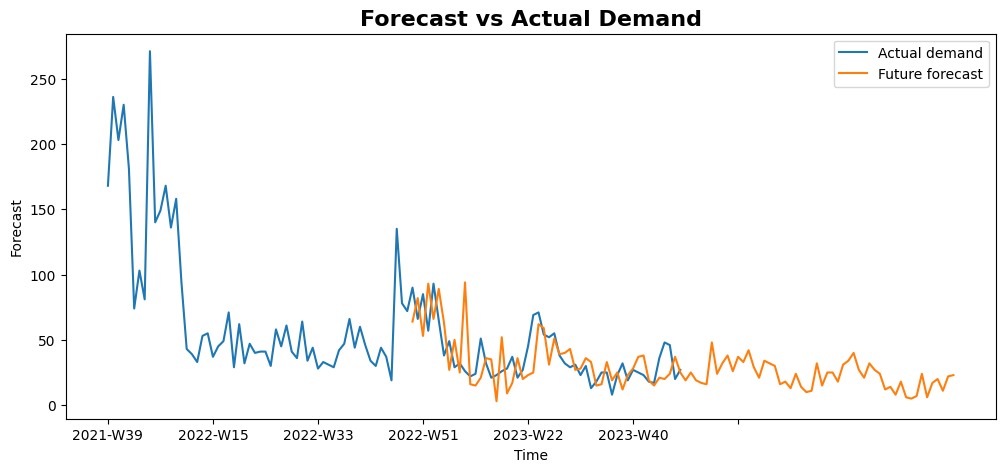

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=885.865, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=912.353, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=893.700, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=884.307, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[20]             : AIC=887.508, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[20]             : AIC=886.052, Time=0.91 sec
 ARIMA(0,1,1)(0,1,2)[20]             : AIC=885.900, Time=0.95 sec
 ARIMA(0,1,1)(1,1,0)[20]             : AIC=886.113, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[20]             : AIC=887.801, Time=1.20 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=905.888, Time=0.30 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=885.917, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=892.062, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[20]             : AIC=887.833, Time=0.99 sec
 ARIMA(0,1,1)(0,1,1)[20] intercept   : AIC=884.932, Time=0.65 sec

Best model:  ARIMA(0,1,1)(0,1,1)

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

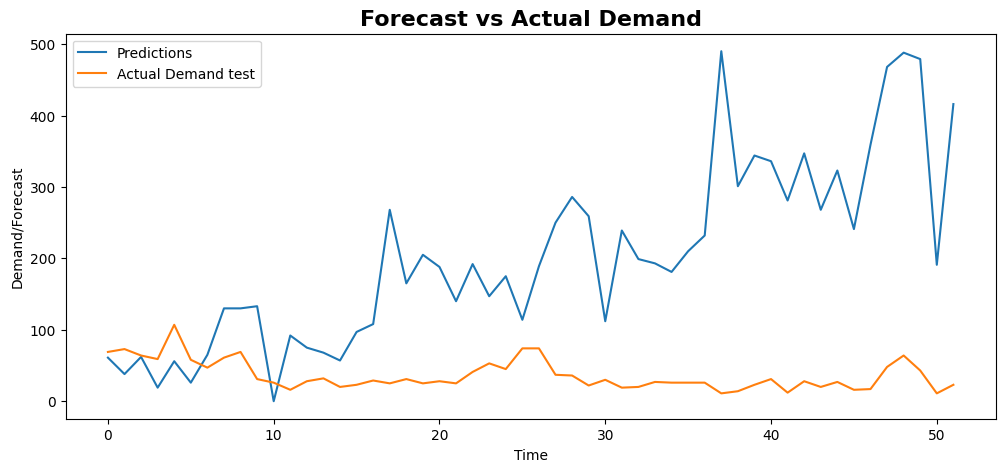

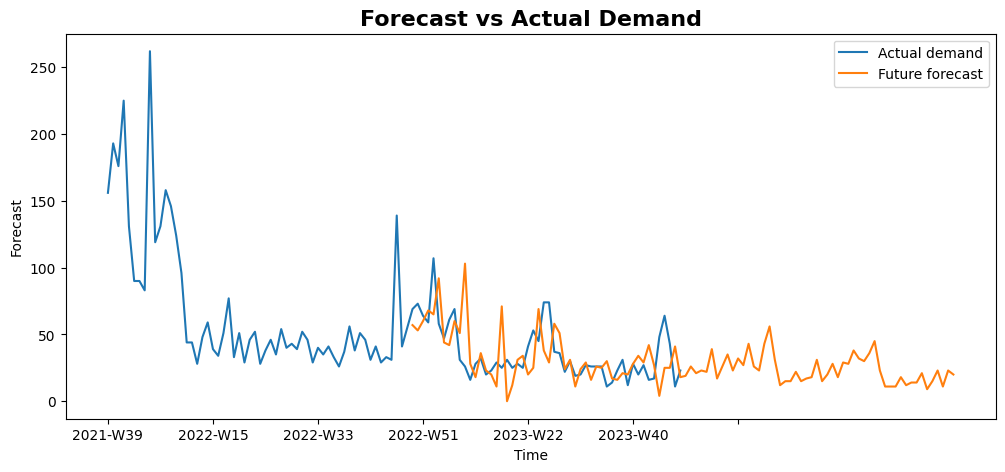

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=881.248, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=900.241, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=889.529, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=882.264, Time=0.33 sec
 ARIMA(1,1,1)(0,1,0)[20]             : AIC=884.942, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[20]             : AIC=882.882, Time=0.84 sec
 ARIMA(1,1,1)(0,1,2)[20]             : AIC=882.801, Time=1.38 sec
 ARIMA(1,1,1)(1,1,0)[20]             : AIC=883.543, Time=0.55 sec
 ARIMA(1,1,1)(1,1,2)[20]             : AIC=884.794, Time=2.13 sec
 ARIMA(1,1,0)(0,1,1)[20]             : AIC=887.444, Time=0.36 sec
 ARIMA(2,1,1)(0,1,1)[20]             : AIC=882.632, Time=0.84 sec
 ARIMA(1,1,2)(0,1,1)[20]             : AIC=882.631, Time=1.34 sec
 ARIMA(0,1,0)(0,1,1)[20]             : AIC=895.002, Time=0.35 sec
 ARIMA(0,1,2)(0,1,1)[20]             : AIC=882.114, Time=0.61 sec
 ARIMA(2,1,0)(0,1,1)[20]         

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

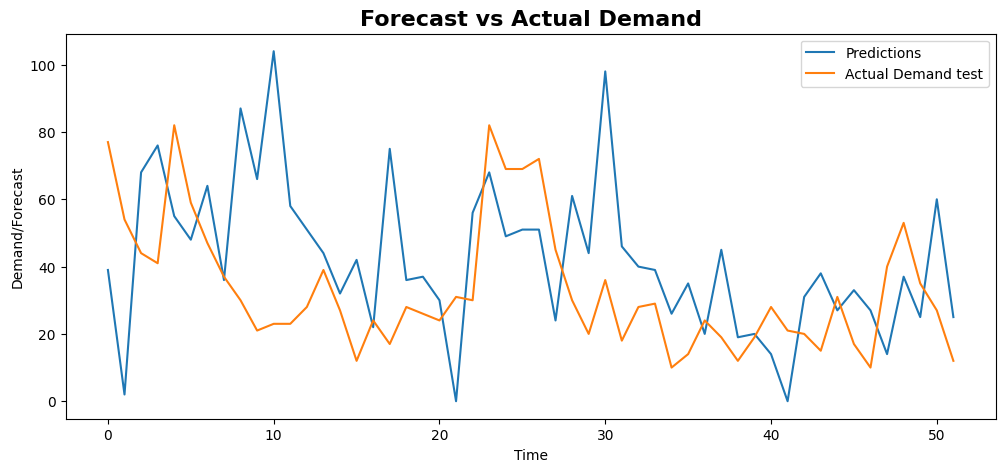

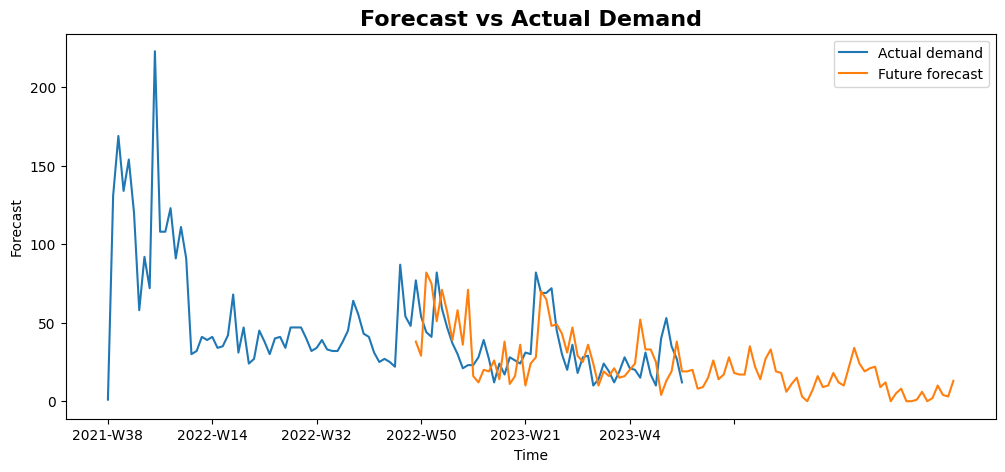

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=805.373, Time=0.76 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=831.304, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=808.285, Time=0.52 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=809.931, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=841.440, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[20] intercept   : AIC=810.484, Time=0.16 sec
 ARIMA(1,0,1)(1,1,1)[20] intercept   : AIC=806.484, Time=1.10 sec
 ARIMA(1,0,1)(0,1,2)[20] intercept   : AIC=805.717, Time=1.67 sec
 ARIMA(1,0,1)(1,1,0)[20] intercept   : AIC=808.952, Time=0.88 sec
 ARIMA(1,0,1)(1,1,2)[20] intercept   : AIC=807.145, Time=1.65 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=804.812, Time=0.46 sec
 ARIMA(1,0,0)(0,1,0)[20] intercept   : AIC=809.887, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=805.880, Time=0.74 sec
 ARIMA(1,0,0)(0,1,2)[20] intercept   : AIC=805.168, Time=1.24 sec
 ARIMA(1,0,0)(1,1,2)[20] intercep

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

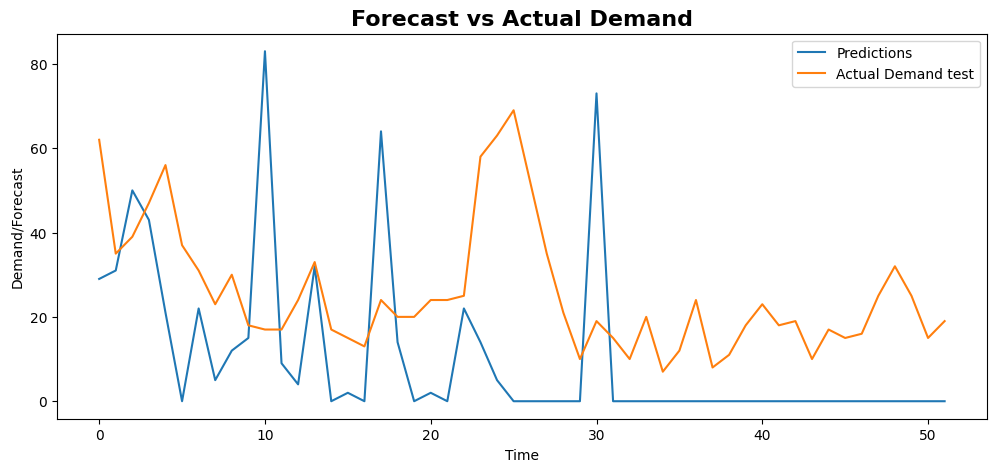

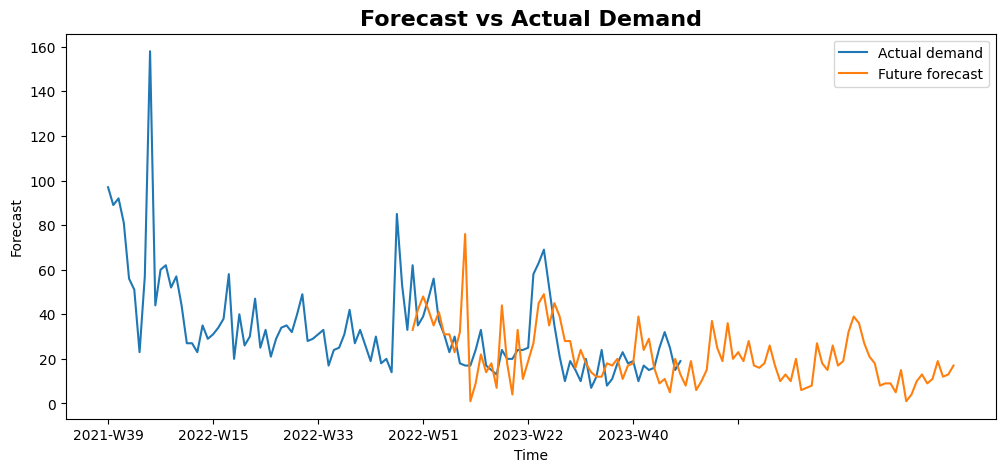

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=727.624, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=761.645, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=733.228, Time=0.56 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=729.981, Time=0.65 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=762.206, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[20] intercept   : AIC=748.514, Time=0.12 sec
 ARIMA(1,0,1)(1,1,1)[20] intercept   : AIC=729.501, Time=1.34 sec
 ARIMA(1,0,1)(0,1,2)[20] intercept   : AIC=729.445, Time=1.50 sec
 ARIMA(1,0,1)(1,1,0)[20] intercept   : AIC=734.219, Time=0.60 sec
 ARIMA(1,0,1)(1,1,2)[20] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=726.695, Time=0.52 sec
 ARIMA(1,0,0)(0,1,0)[20] intercept   : AIC=748.104, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=728.558, Time=0.91 sec
 ARIMA(1,0,0)(0,1,2)[20] intercept   : AIC=728.502, Time=1.08 sec
 ARIMA(1,0,0)(1,1,2)[20] intercept   

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

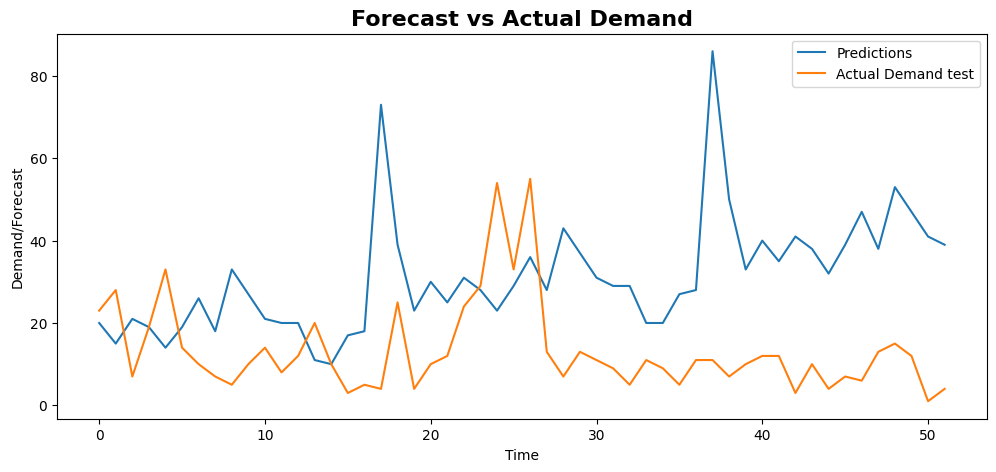

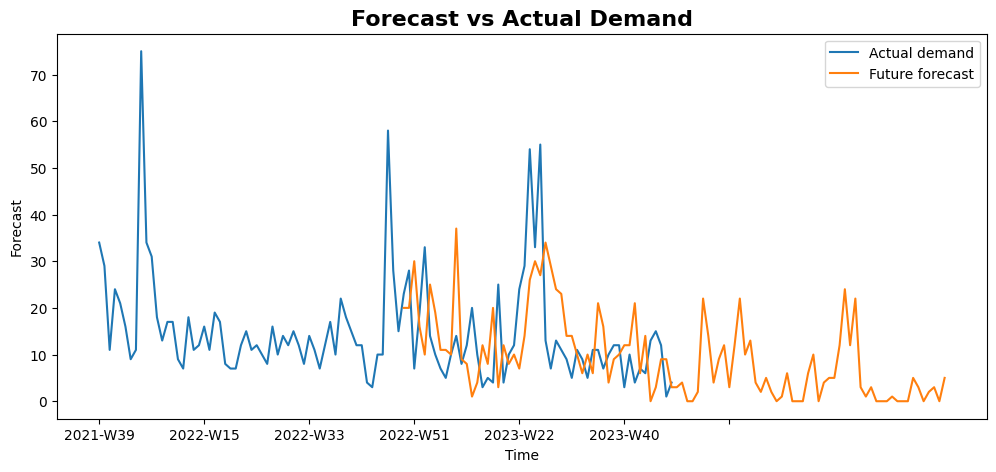

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=738.739, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=767.888, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=744.885, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=769.592, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[20] intercept   : AIC=754.881, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[20] intercept   : AIC=740.720, Time=0.96 sec
 ARIMA(1,0,1)(0,1,2)[20] intercept   : AIC=740.712, Time=1.55 sec
 ARIMA(1,0,1)(1,1,0)[20] intercept   : AIC=746.281, Time=0.72 sec
 ARIMA(1,0,1)(1,1,2)[20] intercept   : AIC=inf, Time=3.73 sec
 ARIMA(1,0,0)(0,1,1)[20] intercept   : AIC=737.651, Time=0.46 sec
 ARIMA(1,0,0)(0,1,0)[20] intercept   : AIC=754.999, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=739.596, Time=0.71 sec
 ARIMA(1,0,0)(0,1,2)[20] intercept   : AIC=739.582, Time=1.13 sec
 ARIMA(1,0,0)(1,1,2)[20] intercept   : AI

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: V

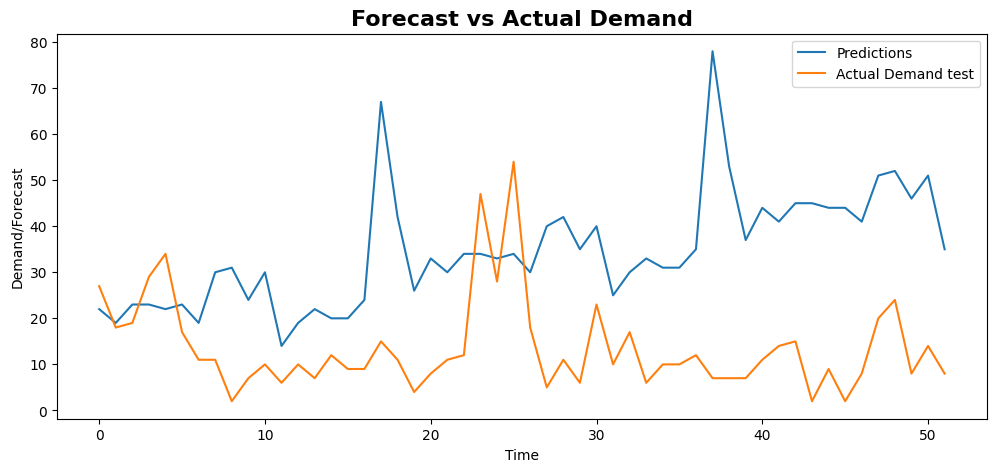

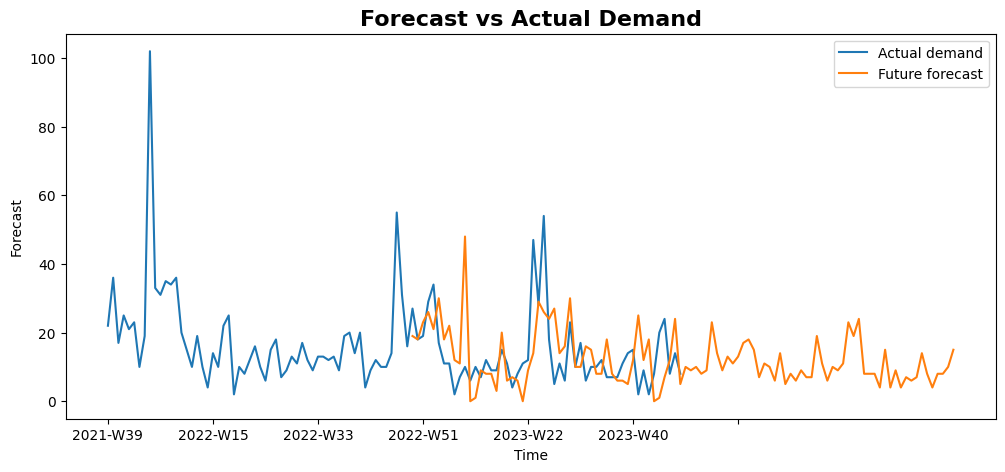

c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bodom\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observati

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4.838, Time=0.00 sec
Total fit time: 0.004 seconds


NameError: name 'predictions_forecast_ARIMA_category' is not defined

In [ ]:
categories_ARIMA = {}

for category, group in combined_df2.groupby('DNA Category '):
    categories_ARIMA[category] = []
    try:   
        predictions_forecast_ARIMA_category, mre_ARIMA_category = ARIMA(data = group)
        categories_ARIMA[category] = [predictions_forecast_ARIMA_category, mre_ARIMA_category]

    except Exception as e:
        categories_ARIMA[category] = [predictions_forecast_ARIMA_category, mre_ARIMA_category]
        #categories_ARIMA[category]["ARIMA"] = []
        print(f"An error occurred with category {category}: {e}")
        continue  # This will skip to the next iteration of the loop
    
    print(predictions_forecast_ARIMA_category)
    print(mre_ARIMA_category)

In [ ]:
d = {}
d = {'Model' : ['Transformers', 'LSTM'],0 : [], 1 : [], 2 : [], 3 : [], 4 : [], 5 : [], 6 : [], 7 : [], 8 : []}
for i in categories:
    d[i] = [int(categories[i]['Transformers'][1]), int(categories[i]['LSTM'][1])]

d_df = pd.DataFrame(d)

latex_code = d_df.to_latex(index=False)
print(latex_code)


\begin{tabular}{lrrrrrrrrr}
\toprule
Model & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\midrule
Transformers & 20 & 17 & 25 & 13 & 16 & 13 & 49 & 92 & 14 \\
LSTM & 12 & 5 & 22 & 8 & 16 & 6 & 58 & 200 & 5 \\
\bottomrule
\end{tabular}



In [ ]:
combined_df2.columns.tolist()

['SKU',
 'Region',
 'Demand',
 'Global Status',
 'DNA Collection ',
 'DNA Category ',
 'DNA Sub Category ',
 'DNA Metal ',
 'DNA Material ',
 'DNA Stones ',
 'DNA Color ',
 'DNA Size ',
 'Date Item Introduced',
 'Date Item Discontinue',
 'Design Variation',
 'Campaign Id',
 'Theme Id',
 'Theme Description',
 'Year',
 'Week_Number',
 'Seasonality',
 'Evolving State',
 'Buckets']

# Save models

In [ ]:
torch.save(model_LSTM, 'model_LSTM.pth')
torch.save(model_transformers, 'model_transformers.pth')

In [ ]:
model_LSTM = torch.load('model_LSTM.pth')
model_transformers = torch.load('model_transformers.pth')


In [ ]:
import csv

# Assuming train_losses is a list of float values

# Saving train_losses to a CSV file
# Transformers
with open('train_losses_transformers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(train_losses_transformers)

with open('val_losses_transformers.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(val_losses_transformers)

# LSTM
with open('train_losses_LSTM.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(train_losses_LSTM)

with open('val_losses_LSTM.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(val_losses_LSTM)


In [ ]:
# Reading train_losses from a CSV file
#Transformers
with open('train_losses_transformers.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        train_losses_transformers = [float(loss) for loss in row]

with open('val_losses_transformers.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        val_losses_transformers = [float(loss) for loss in row]

# LSTM
with open('train_losses_LSTM.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        train_losses_LSTM = [float(loss) for loss in row]

with open('val_losses_transformers.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        val_losses_LSTM = [float(loss) for loss in row]

[0.5, 0.4, 0.3]
